<a href="https://colab.research.google.com/github/Alfredo-GL-Franco/Analysis-of-avocado-ripening-with-spectroscopy-using-NIR-and-applying-machine-learning-techniques.-/blob/main/EDA_PALTA_1_fuerte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Este codigo es la primera prueba de EDA sobre el estado de maduracion de la palta utilizando NIR Y %**DMC**  **

En esta primera etapa vamos a recorrer toda la carpeta de la variedad fuerte para generar un solo dataframe con el consolidado de todos los espectros.

In [ ]:
import os
import pandas as pd
import re
from pathlib import Path


import numpy as np
from typing import List, Dict, Tuple, Optional
import logging
from google.colab import drive
#drive.mount('/content/drive')

# Configurar logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class SpectralDataConsolidator:
    """
    Consolida archivos Excel de espectros en un DataFrame único y ordenado
    Optimizado para estructura: 1 archivo por punto (muestra-punto)
    """

    def __init__(self, carpeta_base: str, skip_rows: int = 5):
        self.carpeta_base = Path(carpeta_base)
        self.skip_rows = skip_rows
        self.archivos_procesados = []
        self.archivos_fallidos = []

    def extraer_metadatos_archivo(self, nombre_archivo: str) -> Dict[str, any]:
        """
        Extrae metadatos del nombre del archivo
        Patrones soportados: m1f-A, m01-B, muestra1_puntoA, etc.
        """
        metadatos = {
            'muestra': None,
            'punto': None,
            'archivo_original': nombre_archivo
        }

        # Patrón principal: m{número}f?-?{letra}
        patron1 = re.search(r'm(\d+)h?-?([A-D])', nombre_archivo, re.IGNORECASE)
        if patron1:
            metadatos['muestra'] = int(patron1.group(1))
            metadatos['punto'] = patron1.group(2).upper()
            return metadatos

        # Patrón alternativo: muestra{número}_punto{letra}
        patron2 = re.search(r'muestra(\d+).*punto([A-D])', nombre_archivo, re.IGNORECASE)
        if patron2:
            metadatos['muestra'] = int(patron2.group(1))
            metadatos['punto'] = patron2.group(2).upper()
            return metadatos

        # Patrón numérico: {número}-{letra}
        patron3 = re.search(r'(\d+)-([A-D])', nombre_archivo, re.IGNORECASE)
        if patron3:
            metadatos['muestra'] = int(patron3.group(1))
            metadatos['punto'] = patron3.group(2).upper()
            return metadatos

        logger.warning(f"No se pudieron extraer metadatos de: {nombre_archivo}")
        return metadatos

    def procesar_archivo_excel(self, ruta_archivo: Path) -> Optional[pd.DataFrame]:
        """
        Procesa un archivo Excel individual
        """
        try:
            logger.info(f"Procesando: {ruta_archivo.name}")

            # Leer archivo Excel
            df = pd.read_excel(ruta_archivo, skiprows=self.skip_rows)

            if df.empty:
                logger.warning(f"Archivo vacío: {ruta_archivo.name}")
                return None

            # Renombrar primera columna como wavelength
            df = df.rename(columns={df.columns[0]: 'wavelength'})

            # Eliminar columnas completamente vacías
            df = df.dropna(axis=1, how='all')

            # Eliminar filas con wavelength NaN
            df = df.dropna(subset=['wavelength'])

            # Extraer metadatos del nombre del archivo
            metadatos = self.extraer_metadatos_archivo(ruta_archivo.name)

            # Identificar columnas de espectros (numéricas, no wavelength)
            columnas_espectro = [col for col in df.columns
                               if col != 'wavelength' and pd.api.types.is_numeric_dtype(df[col])]

            if not columnas_espectro:
                logger.warning(f"No se encontraron columnas de espectro en: {ruta_archivo.name}")
                return None

            # Reestructurar datos: de formato ancho a largo
            # Cada fila será: wavelength, intensidad, muestra, punto, medicion_id
            datos_largos = []

            for i, col_espectro in enumerate(columnas_espectro):
                df_temp = df[['wavelength', col_espectro]].copy()
                df_temp = df_temp.dropna()  # Eliminar NaN en espectro

                # Agregar metadatos
                df_temp['muestra'] = metadatos['muestra']
                df_temp['punto'] = metadatos['punto']
                df_temp['medicion_id'] = i + 1  # ID de medición dentro del punto
                df_temp['archivo_original'] = metadatos['archivo_original']

                # Renombrar columna de intensidad
                df_temp = df_temp.rename(columns={col_espectro: 'intensidad'})

                datos_largos.append(df_temp)

            # Concatenar todas las mediciones del archivo
            if datos_largos:
                df_final = pd.concat(datos_largos, ignore_index=True)

                # Crear ID único para cada espectro
                df_final['espectro_id'] = (
                    df_final['muestra'].astype(str) + '_' +
                    df_final['punto'] + '_' +
                    df_final['medicion_id'].astype(str)
                )

                logger.info(f"✅ Procesado {ruta_archivo.name}: {len(columnas_espectro)} espectros, {len(df_final)} puntos espectrales")
                self.archivos_procesados.append(ruta_archivo.name)
                return df_final

        except Exception as e:
            logger.error(f"❌ Error procesando {ruta_archivo.name}: {str(e)}")
            self.archivos_fallidos.append((ruta_archivo.name, str(e)))
            return None

    def consolidar_todos_archivos(self) -> pd.DataFrame:
        """
        Consolida todos los archivos Excel en un DataFrame único
        """
        logger.info(f"🔄 Iniciando consolidación en: {self.carpeta_base}")

        if not self.carpeta_base.exists():
            raise FileNotFoundError(f"Carpeta no existe: {self.carpeta_base}")

        # Encontrar todos los archivos Excel
        archivos_excel = list(self.carpeta_base.glob('*.xlsx')) + list(self.carpeta_base.glob('*.xls'))

        if not archivos_excel:
            logger.warning("No se encontraron archivos Excel")
            return pd.DataFrame()

        logger.info(f"📁 Encontrados {len(archivos_excel)} archivos Excel")

        # Procesar cada archivo
        dataframes = []
        for archivo in archivos_excel:
            df_procesado = self.procesar_archivo_excel(archivo)
            if df_procesado is not None:
                dataframes.append(df_procesado)

        # Consolidar todos los DataFrames
        if dataframes:
            df_consolidado = pd.concat(dataframes, ignore_index=True)

            # Ordenar datos
            df_consolidado = df_consolidado.sort_values([
                'muestra', 'punto', 'medicion_id', 'wavelength'
            ]).reset_index(drop=True)

            logger.info(f"✅ Consolidación completada:")
            logger.info(f"   • Total espectros individuales: {df_consolidado['espectro_id'].nunique()}")
            logger.info(f"   • Total puntos espectrales: {len(df_consolidado)}")
            logger.info(f"   • Muestras: {df_consolidado['muestra'].nunique()}")
            logger.info(f"   • Puntos por muestra: {df_consolidado['punto'].nunique()}")
            logger.info(f"   • Rango wavelength: {df_consolidado['wavelength'].min():.1f} - {df_consolidado['wavelength'].max():.1f}")

            return df_consolidado

        else:
            logger.error("❌ No se pudieron procesar archivos")
            return pd.DataFrame()

    def convertir_a_formato_ancho(self, df_largo: pd.DataFrame) -> pd.DataFrame:
        """
        Convierte formato largo a ancho para análisis ML
        Cada fila = un espectro completo
        """
        logger.info("🔄 Convirtiendo a formato ancho para ML...")

        # Crear tabla pivote
        df_ancho = df_largo.pivot_table(
            index=['espectro_id', 'muestra', 'punto', 'medicion_id', 'archivo_original'],
            columns='wavelength',
            values='intensidad',
            aggfunc='mean'  # En caso de duplicados
        ).reset_index()

        # Aplanar nombres de columnas
        df_ancho.columns.name = None
        wavelength_cols = [col for col in df_ancho.columns if isinstance(col, (int, float))]
        df_ancho = df_ancho.rename(columns={col: f'wl_{col}' for col in wavelength_cols})

        logger.info(f"✅ Formato ancho creado: {df_ancho.shape[0]} espectros × {len(wavelength_cols)} wavelengths")

        return df_ancho

    def generar_reporte_consolidacion(self, df: pd.DataFrame) -> Dict:
        """
        Genera reporte detallado de la consolidación
        """
        if df.empty:
            return {"error": "DataFrame vacío"}

        # Análisis por muestra y punto
        resumen_por_punto = df.groupby(['muestra', 'punto']).agg({
            'espectro_id': 'nunique',
            'wavelength': ['min', 'max', 'nunique'],
            'intensidad': ['mean', 'std']
        }).round(3)

        reporte = {
            "resumen_general": {
                "total_espectros": df['espectro_id'].nunique(),
                "total_puntos_espectrales": len(df),
                "muestras_unicas": df['muestra'].nunique(),
                "puntos_unicos": df['punto'].nunique(),
                "rango_wavelength": (df['wavelength'].min(), df['wavelength'].max()),
                "archivos_procesados": len(self.archivos_procesados),
                "archivos_fallidos": len(self.archivos_fallidos)
            },
            "distribucion_por_muestra": df.groupby('muestra')['espectro_id'].nunique().to_dict(),
            "distribucion_por_punto": df.groupby('punto')['espectro_id'].nunique().to_dict(),
            "resumen_por_punto": resumen_por_punto,
            "archivos_exitosos": self.archivos_procesados,
            "archivos_con_errores": self.archivos_fallidos
        }

        return reporte

    def guardar_datos_consolidados(self, df: pd.DataFrame, formato: str = 'parquet') -> str:
        """
        Guarda datos consolidados en formato eficiente
        """
        output_dir = self.carpeta_base / "datos_consolidados"
        output_dir.mkdir(exist_ok=True)

        if formato == 'parquet':
            archivo_salida = output_dir / "espectros_consolidados.parquet"
            df.to_parquet(archivo_salida, compression='snappy')
        elif formato == 'csv':
            archivo_salida = output_dir / "espectros_consolidados.csv"
            df.to_csv(archivo_salida, index=False)
        elif formato == 'excel':
            archivo_salida = output_dir / "espectros_consolidados.xlsx"
            df.to_excel(archivo_salida, index=False)

        logger.info(f"💾 Datos guardados en: {archivo_salida}")
        return str(archivo_salida)

def main():
    """
    Función principal - Ejemplo de uso
    """
    # Configuración
    carpeta_datos = '/content/drive/MyDrive/Verano_delfin/Avance_data/NUEVA DATA/TESIS DATOS/TESIS DATOS/HASS'

    # Crear consolidador
    consolidador = SpectralDataConsolidator(carpeta_datos, skip_rows=5)

    # Consolidar archivos
    print("🚀 INICIANDO CONSOLIDACIÓN DE DATOS ESPECTRALES")
    print("=" * 60)

    df_consolidado = consolidador.consolidar_todos_archivos()

    if not df_consolidado.empty:
        # Generar reporte
        reporte = consolidador.generar_reporte_consolidacion(df_consolidado)

        print("\n📊 REPORTE DE CONSOLIDACIÓN:")
        print("-" * 40)
        for seccion, datos in reporte["resumen_general"].items():
            print(f"{seccion}: {datos}")

        print(f"\n📈 DISTRIBUCIÓN POR MUESTRA:")
        for muestra, count in reporte["distribucion_por_muestra"].items():
            print(f"   Muestra {muestra}: {count} espectros")

        print(f"\n📍 DISTRIBUCIÓN POR PUNTO:")
        for punto, count in reporte["distribucion_por_punto"].items():
            print(f"   Punto {punto}: {count} espectros")

        # Mostrar muestra de datos
        print(f"\n🔍 MUESTRA DE DATOS (primeras 5 filas):")
        print(df_consolidado.head())

        # Convertir a formato ancho para ML
        print(f"\n🔄 CONVIRTIENDO A FORMATO ANCHO PARA ML...")
        df_ancho = consolidador.convertir_a_formato_ancho(df_consolidado)

        print(f"\n📐 FORMATO ANCHO (ML-ready):")
        print(f"   Shape: {df_ancho.shape}")
        print(f"   Columnas: {list(df_ancho.columns[:10])}...")  # Primeras 10

        # Guardar datos
        archivo_guardado = consolidador.guardar_datos_consolidados(df_consolidado, formato='parquet')

        print(f"\n✅ CONSOLIDACIÓN COMPLETADA")
        print(f"📁 Datos guardados en: {archivo_guardado}")

        return df_consolidado, df_ancho

    else:
        print("❌ No se pudieron consolidar los datos")
        return None, None

if __name__ == "__main__":
    df_largo, df_ancho = main()


🚀 INICIANDO CONSOLIDACIÓN DE DATOS ESPECTRALES

📊 REPORTE DE CONSOLIDACIÓN:
----------------------------------------
total_espectros: 12900
total_puntos_espectrales: 2618700
muestras_unicas: 32
puntos_unicos: 4
rango_wavelength: (903.4703528544339, 1700.8300273203536)
archivos_procesados: 128
archivos_fallidos: 0

📈 DISTRIBUCIÓN POR MUESTRA:
   Muestra 1: 400 espectros
   Muestra 2: 400 espectros
   Muestra 3: 400 espectros
   Muestra 4: 400 espectros
   Muestra 5: 400 espectros
   Muestra 6: 400 espectros
   Muestra 7: 400 espectros
   Muestra 8: 400 espectros
   Muestra 9: 400 espectros
   Muestra 10: 400 espectros
   Muestra 11: 500 espectros
   Muestra 12: 400 espectros
   Muestra 13: 400 espectros
   Muestra 14: 400 espectros
   Muestra 15: 400 espectros
   Muestra 16: 400 espectros
   Muestra 17: 400 espectros
   Muestra 18: 400 espectros
   Muestra 19: 400 espectros
   Muestra 20: 400 espectros
   Muestra 21: 400 espectros
   Muestra 22: 400 espectros
   Muestra 23: 400 espectro

Separar los datos para train, test y validation

In [ ]:


from sklearn.model_selection import train_test_split
if df_ancho is not None and not df_ancho.empty:

    train_df, temp_df = train_test_split(df_ancho, test_size=0.40, random_state=42) # 40% para temp (validation + test)

    # Luego, separar el 20% restante (temp_df) en validation (50% de temp) y test (50% de temp)
    # Esto resulta en 20% validation y 20% test (50% de 40% = 20%)
    validation_df, test_df = train_test_split(temp_df, test_size=0.625, random_state=42)

    print(f"\n📊 Datos separados:")
    print(f"   Train (60%): {train_df.shape[0]} espectros")
    print(f"   Validation (15%): {validation_df.shape[0]} espectros")
    print(f"   Test (25%): {test_df.shape[0]} espectros")

    # Puedes mostrar una muestra de cada set si lo deseas
    # print("\nTrain sample:")
    # print(train_df.head())
    # print("\nValidation sample:")
    # print(validation_df.head())
    # print("\nTest sample:")
    # print(test_df.head())

else:
    print("\n❌ No se pudo realizar la separación de datos. df_ancho está vacío o es None.")




📊 Datos separados:
   Train (60%): 7740 espectros
   Validation (15%): 1935 espectros
   Test (25%): 3225 espectros


### Aplicar SNV (Standard Normal Variate)

SNV Es un método utilizado para eliminar los efectos de dispersión en los espectros de reflectancia. Para cada espectro (fila), se resta la media y se divide entre la desviación estándar.

In [ ]:
from sklearn.preprocessing import StandardScaler

#encontrar columnas
wavelength_cols = [col for col in df_ancho.columns if col.startswith('wl_')]

# extraer la data
X_spectra_train = train_df[wavelength_cols].values
X_spectra_test = test_df[wavelength_cols].values
X_spectra_vali = validation_df[wavelength_cols].values


# SNV (axis=1)
scaler = StandardScaler()
X_spectra_snv_train = scaler.fit_transform(X_spectra_train.T).T #   data transpuesta
X_spectra_snv_test = scaler.fit_transform(X_spectra_test.T).T
X_spectra_snv_vali = scaler.fit_transform(X_spectra_vali.T).T

# Crear un nuevo df
train_df_snv = train_df.copy()
train_df_snv[wavelength_cols] = X_spectra_snv_train

test_df_snv = test_df.copy()
test_df_snv[wavelength_cols] = X_spectra_snv_test

vali_df_snv = validation_df.copy()
vali_df_snv[wavelength_cols] = X_spectra_snv_vali


print("SNV creado correctamente.")
display(train_df_snv.head())
display(train_df_snv.shape)

display(test_df_snv.head())
display(test_df_snv.shape)

display(vali_df_snv.head())
display(vali_df_snv.shape)

SNV creado correctamente.


,espectro_id,muestra,punto,medicion_id,archivo_original,wl_903.4703528544339,wl_907.5942554204732,wl_911.7169620615639,wl_915.8384643617376,wl_919.958753905026,...,wl_1667.297839794257,wl_1671.034997784624,wl_1674.7693355681613,wl_1678.5008447289006,wl_1682.2295168508736,wl_1685.955343518112,wl_1689.6783163146474,wl_1693.3984268245117,wl_1697.1156666317365,wl_1700.8300273203536
947,12_A_51,12,A,51,M12H-A.xlsx,3.683586,3.364712,3.051922,2.291792,2.204865,...,2.110385,2.226939,2.387728,2.470151,2.527302,2.601055,2.685975,2.729984,2.755823,3.003281
9969,32_C_71,32,C,71,M32H-C.xlsx,3.640638,3.511594,2.865229,2.030262,2.412692,...,-1.834365,-1.948400,-2.236495,-2.522755,-2.768765,-2.604828,-2.638873,-2.651344,-2.579420,-2.281249
11780,7_A_81,7,A,81,M7H-A.xlsx,6.181545,6.349538,4.300838,2.478228,3.359828,...,-0.271004,-0.241903,-0.363058,-0.503164,-0.577586,-0.373368,-0.502467,-0.444775,-0.420144,-0.192628
1280,12_D_81,12,D,81,M12H-D.xlsx,3.910050,3.781719,3.562411,2.882232,3.016798,...,1.091995,1.293921,1.297427,1.370233,1.346030,1.631580,1.667162,1.905192,2.017755,2.355769
122,10_B_29,10,B,29,M10H-B.xlsx,-3.785039,-4.016361,-3.837165,-4.838369,-4.245988,...,-0.111428,-0.260380,-0.548250,-1.126871,-1.293011,-1.423329,-1.763672,-1.906100,-2.467508,-3.249852


(7740, 208)

,espectro_id,muestra,punto,medicion_id,archivo_original,wl_903.4703528544339,wl_907.5942554204732,wl_911.7169620615639,wl_915.8384643617376,wl_919.958753905026,...,wl_1667.297839794257,wl_1671.034997784624,wl_1674.7693355681613,wl_1678.5008447289006,wl_1682.2295168508736,wl_1685.955343518112,wl_1689.6783163146474,wl_1693.3984268245117,wl_1697.1156666317365,wl_1700.8300273203536
1463,13_B_66,13,B,66,M13H-B.xlsx,4.240750,4.472611,4.002361,3.018086,3.326801,...,0.812432,0.936675,0.879668,0.801444,0.738503,0.978964,0.906405,0.938524,1.070000,1.377530
10008,32_D_16,32,D,16,M32H-D.xlsx,3.807482,3.684387,3.194204,2.329264,2.653941,...,-1.643911,-1.714694,-1.925397,-2.136470,-2.384277,-2.151336,-2.222082,-2.207612,-2.164906,-1.878653
8072,28_D_74,28,D,74,M28H-D.xlsx,2.974455,2.815281,2.650430,1.979427,2.206595,...,-2.167874,-2.303759,-2.547310,-2.733904,-2.952160,-2.766525,-2.772360,-2.615685,-2.450671,-2.011337
3065,17_B_68,17,B,68,M17H-B.xlsx,0.856394,1.142186,0.584196,0.054230,0.266191,...,-2.779083,-2.852490,-3.194458,-3.451663,-3.839019,-3.698061,-3.928640,-3.592214,-3.328397,-2.863182
8268,29_B_70,29,B,70,M29H-B.xlsx,1.464966,1.598175,1.352037,0.890537,1.209135,...,-2.442672,-2.686990,-2.981703,-3.319981,-3.585399,-3.582691,-3.577926,-3.576246,-3.491732,-3.172497


(3225, 208)

,espectro_id,muestra,punto,medicion_id,archivo_original,wl_903.4703528544339,wl_907.5942554204732,wl_911.7169620615639,wl_915.8384643617376,wl_919.958753905026,...,wl_1667.297839794257,wl_1671.034997784624,wl_1674.7693355681613,wl_1678.5008447289006,wl_1682.2295168508736,wl_1685.955343518112,wl_1689.6783163146474,wl_1693.3984268245117,wl_1697.1156666317365,wl_1700.8300273203536
7191,26_C_91,26,C,91,M26H-C.xlsx,1.933663,1.869123,1.829329,1.343361,1.626792,...,-2.610150,-2.813718,-3.090362,-3.397341,-3.661149,-3.516043,-3.458323,-3.362402,-3.150332,-2.566416
2948,17_A_52,17,A,52,M17H-A.xlsx,-2.022864,-1.640293,-1.870120,-2.094212,-1.654557,...,-2.532658,-2.706912,-2.943428,-3.315305,-3.607378,-3.735603,-3.929363,-3.715287,-3.618049,-3.518175
5952,23_C_56,23,C,56,M23H-C.xlsx,-1.335805,-1.388429,-1.214644,-1.623001,-0.953222,...,-2.266968,-2.611792,-3.159431,-3.419291,-3.923053,-3.660346,-3.436287,-3.190392,-3.401330,-2.619629
6225,24_B_31,24,B,31,M24H-B.xlsx,0.761006,0.786165,0.854376,0.349027,0.672304,...,-2.647756,-2.970711,-3.301738,-3.628124,-4.030907,-3.907805,-3.892377,-3.794749,-3.543573,-2.938420
3000,17_B_1,17,B,1,M17H-B.xlsx,2.006609,2.110540,1.510003,0.932169,1.050897,...,-2.546436,-2.643587,-2.886920,-3.151061,-3.419856,-3.359632,-3.463941,-3.039305,-2.802687,-2.318999


(1935, 208)

### Aplicar Savitzky-Golay Derivative

El Savitzky-Golay filtro, ayuda a eliminar ruido y suavizar

In [ ]:
from scipy.signal import savgol_filter



# Identificar las columnas
wavelenght_cols_train = [col for col in train_df_snv.columns if col.startswith('wl_')]
wavelenght_cols_vali = [col for col in vali_df_snv.columns if col.startswith('wl_')]
wavelenght_cols_test = [col for col in test_df_snv.columns if col.startswith('wl_')]


# Extraer (SNV transformed)
X_spectra_snv_train = train_df_snv[wavelenght_cols_train].values
X_spectra_snv_test= test_df_snv[wavelenght_cols_test].values
X_spectra_snv_vali = vali_df_snv[wavelenght_cols_vali].values


#
# window_length: Debe ser un número impar y menor que la cantidad de puntos.
# polyorder: El orden del polinomio debe ser menor que la longitud de la ventana.
window_length = 13 #
polyorder = 2      #

# Aplicar el filtro para cada columna (row)
X_spectra_sg_train = savgol_filter(X_spectra_snv_train, window_length, polyorder, deriv=1, axis=1)
X_spectra_sg_test = savgol_filter(X_spectra_snv_test, window_length, polyorder, deriv=1, axis=1)
X_spectra_sg_vali = savgol_filter(X_spectra_snv_vali, window_length, polyorder, deriv=1, axis=1)

# Crear un nuevo df
train_df_sg = train_df_snv.copy()
train_df_sg[wavelenght_cols_train] = X_spectra_sg_train

test_df_sg = test_df_snv.copy()
test_df_sg[wavelenght_cols_test] = X_spectra_sg_test

vali_df_sg = vali_df_snv.copy()
vali_df_sg[wavelenght_cols_vali] = X_spectra_sg_vali

print("Savitzky-Golay derivative applicado correctamente.")
display(train_df_sg.head())
display(train_df_sg.shape)

display(test_df_sg.head())
display(test_df_sg.shape)

display(vali_df_sg.head())
display(vali_df_sg.shape)

Savitzky-Golay derivative applicado correctamente.


,espectro_id,muestra,punto,medicion_id,archivo_original,wl_903.4703528544339,wl_907.5942554204732,wl_911.7169620615639,wl_915.8384643617376,wl_919.958753905026,...,wl_1667.297839794257,wl_1671.034997784624,wl_1674.7693355681613,wl_1678.5008447289006,wl_1682.2295168508736,wl_1685.955343518112,wl_1689.6783163146474,wl_1693.3984268245117,wl_1697.1156666317365,wl_1700.8300273203536
947,12_A_51,12,A,51,M12H-A.xlsx,-0.480223,-0.436129,-0.392036,-0.347942,-0.303849,...,0.117595,0.108445,0.097568,0.094293,0.089425,0.084556,0.079688,0.074820,0.069952,0.065084
9969,32_C_71,32,C,71,M32H-C.xlsx,-0.394705,-0.347051,-0.299397,-0.251743,-0.204088,...,-0.140780,-0.136479,-0.123707,-0.096013,-0.065138,-0.034263,-0.003387,0.027488,0.058363,0.089238
11780,7_A_81,7,A,81,M7H-A.xlsx,-0.944666,-0.831518,-0.718370,-0.605221,-0.492073,...,-0.021353,-0.023596,-0.021790,-0.010642,-0.000635,0.009372,0.019379,0.029386,0.039393,0.049400
1280,12_D_81,12,D,81,M12H-D.xlsx,-0.322808,-0.294619,-0.266430,-0.238241,-0.210052,...,0.094110,0.097870,0.102163,0.113665,0.125203,0.136741,0.148280,0.159818,0.171356,0.182894
122,10_B_29,10,B,29,M10H-B.xlsx,-0.098496,-0.017045,0.064405,0.145856,0.227307,...,-0.157627,-0.188146,-0.219511,-0.256895,-0.294957,-0.333019,-0.371081,-0.409143,-0.447205,-0.485267


(7740, 208)

,espectro_id,muestra,punto,medicion_id,archivo_original,wl_903.4703528544339,wl_907.5942554204732,wl_911.7169620615639,wl_915.8384643617376,wl_919.958753905026,...,wl_1667.297839794257,wl_1671.034997784624,wl_1674.7693355681613,wl_1678.5008447289006,wl_1682.2295168508736,wl_1685.955343518112,wl_1689.6783163146474,wl_1693.3984268245117,wl_1697.1156666317365,wl_1700.8300273203536
1463,13_B_66,13,B,66,M13H-B.xlsx,-0.403677,-0.365839,-0.328000,-0.290162,-0.252323,...,0.037034,0.031176,0.029935,0.040213,0.047484,0.054755,0.062026,0.069297,0.076568,0.083839
10008,32_D_16,32,D,16,M32H-D.xlsx,-0.389384,-0.342298,-0.295212,-0.248125,-0.201039,...,-0.106197,-0.101877,-0.090707,-0.067885,-0.042175,-0.016465,0.009245,0.034955,0.060665,0.086375
8072,28_D_74,28,D,74,M28H-D.xlsx,-0.264045,-0.232712,-0.201379,-0.170046,-0.138713,...,-0.128493,-0.113448,-0.088755,-0.049883,-0.005975,0.037933,0.081841,0.125748,0.169656,0.213564
3065,17_B_68,17,B,68,M17H-B.xlsx,-0.220399,-0.180918,-0.141437,-0.101956,-0.062475,...,-0.220765,-0.199507,-0.161010,-0.106263,-0.050888,0.004488,0.059864,0.115240,0.170616,0.225992
8268,29_B_70,29,B,70,M29H-B.xlsx,-0.167420,-0.140392,-0.113364,-0.086336,-0.059308,...,-0.196891,-0.188890,-0.171016,-0.137600,-0.099111,-0.060622,-0.022133,0.016356,0.054845,0.093334


(3225, 208)

,espectro_id,muestra,punto,medicion_id,archivo_original,wl_903.4703528544339,wl_907.5942554204732,wl_911.7169620615639,wl_915.8384643617376,wl_919.958753905026,...,wl_1667.297839794257,wl_1671.034997784624,wl_1674.7693355681613,wl_1678.5008447289006,wl_1682.2295168508736,wl_1685.955343518112,wl_1689.6783163146474,wl_1693.3984268245117,wl_1697.1156666317365,wl_1700.8300273203536
7191,26_C_91,26,C,91,M26H-C.xlsx,-0.184899,-0.158001,-0.131102,-0.104203,-0.077305,...,-0.184575,-0.166525,-0.136156,-0.085219,-0.029390,0.026439,0.082268,0.138097,0.193926,0.249755
2948,17_A_52,17,A,52,M17H-A.xlsx,0.064667,0.077385,0.090103,0.102821,0.115539,...,-0.254061,-0.239578,-0.212742,-0.176308,-0.135690,-0.095071,-0.054453,-0.013834,0.026784,0.067403
5952,23_C_56,23,C,56,M23H-C.xlsx,-0.126646,-0.079938,-0.033231,0.013477,0.060184,...,-0.261767,-0.233716,-0.202914,-0.139312,-0.067606,0.004101,0.075808,0.147514,0.219221,0.290927
6225,24_B_31,24,B,31,M24H-B.xlsx,-0.178392,-0.147424,-0.116456,-0.085488,-0.054520,...,-0.235194,-0.218492,-0.186071,-0.130673,-0.067928,-0.005183,0.057563,0.120308,0.183053,0.245799
3000,17_B_1,17,B,1,M17H-B.xlsx,-0.262502,-0.221699,-0.180895,-0.140092,-0.099289,...,-0.191706,-0.167625,-0.128338,-0.073520,-0.015445,0.042629,0.100704,0.158778,0.216853,0.274927


(1935, 208)

# **GRAFICAR LOS ESPECTROS EN CADA PARTE DEL PROCESO
**

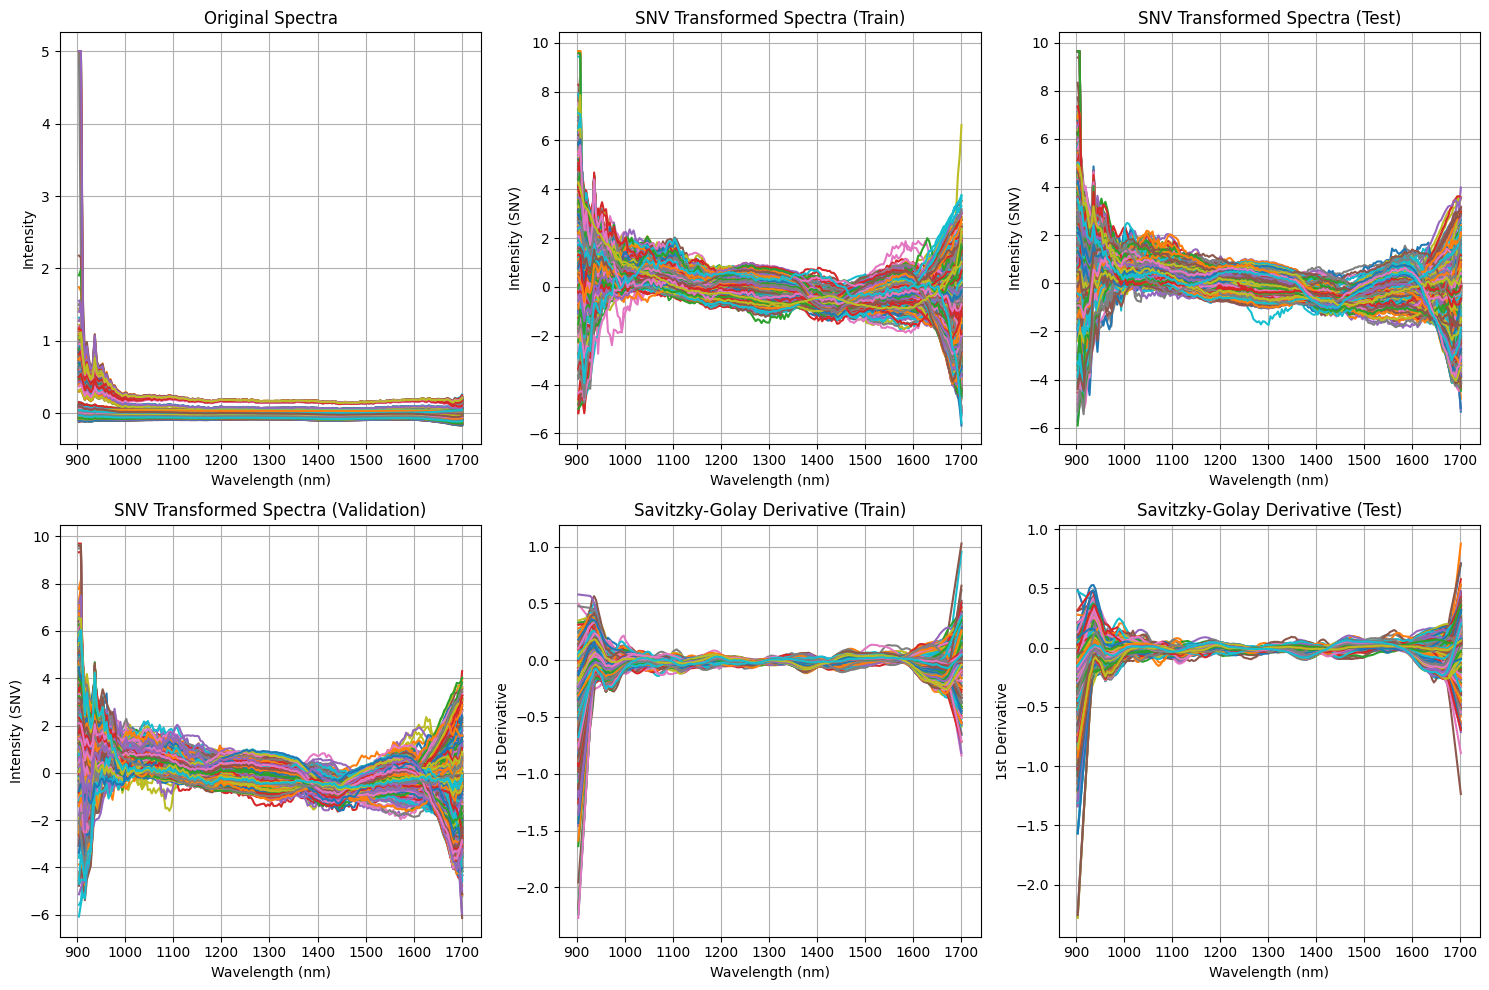

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar numero de espectros

num_example_spectra = 1000 # Reducir el numero de muestras


train_spec_ids = set(train_df_snv['espectro_id'].unique())
test_spec_ids = set(test_df_snv['espectro_id'].unique())
vali_spec_ids = set(vali_df_snv['espectro_id'].unique())


all_split_ids = list(train_spec_ids.union(test_spec_ids).union(vali_spec_ids))
np.random.shuffle(all_split_ids)
example_spectrum_ids_original = all_split_ids[:num_example_spectra]


# Obtener logitudes de onda columna
wavelength_cols = [col for col in df_ancho.columns if col.startswith('wl_')]
wavelengths = [float(col.replace('wl_', '')) for col in wavelength_cols]

plt.figure(figsize=(15, 10))

# Plot Original Spectra
plt.subplot(2, 3, 1)
for spec_id in example_spectrum_ids_original:
    # Check si el spectrum ID existe en el original dataframe
    if spec_id in df_ancho['espectro_id'].values:
        spectrum_data = df_ancho[df_ancho['espectro_id'] == spec_id][wavelength_cols].iloc[0].values
        plt.plot(wavelengths, spectrum_data, label=spec_id)
plt.title('Original Spectra')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.grid(True)
# plt.legend()


# Plot SNV Transformed Spectra
plt.subplot(2, 3, 2)

# Seleccionar un pequeño numero random muestras de IDs
example_spectrum_ids_train_snv = np.random.choice(list(train_spec_ids), min(num_example_spectra, len(train_spec_ids)), replace=False)
for spec_id in example_spectrum_ids_train_snv:
    spectrum_data_snv = train_df_snv[train_df_snv['espectro_id'] == spec_id][wavelength_cols].iloc[0].values
    plt.plot(wavelengths, spectrum_data_snv, label=spec_id)
plt.title('SNV Transformed Spectra (Train)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (SNV)')
plt.grid(True)

plt.subplot(2, 3, 3)
example_spectrum_ids_test_snv = np.random.choice(list(test_spec_ids), min(num_example_spectra, len(test_spec_ids)), replace=False)
for spec_id in example_spectrum_ids_test_snv:
    spectrum_data_snv = test_df_snv[test_df_snv['espectro_id'] == spec_id][wavelength_cols].iloc[0].values
    plt.plot(wavelengths, spectrum_data_snv, label=spec_id)
plt.title('SNV Transformed Spectra (Test)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (SNV)')
plt.grid(True)

plt.subplot(2, 3, 4)
example_spectrum_ids_vali_snv = np.random.choice(list(vali_spec_ids), min(num_example_spectra, len(vali_spec_ids)), replace=False)
for spec_id in example_spectrum_ids_vali_snv:
    spectrum_data_snv = vali_df_snv[vali_df_snv['espectro_id'] == spec_id][wavelength_cols].iloc[0].values
    plt.plot(wavelengths, spectrum_data_snv, label=spec_id)
plt.title('SNV Transformed Spectra (Validation)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (SNV)')
plt.grid(True)


# Plot Savitzky-Golay Derivative Spectra
plt.subplot(2, 3, 5)

example_spectrum_ids_train_sg = np.random.choice(list(train_spec_ids), min(num_example_spectra, len(train_spec_ids)), replace=False)
for spec_id in example_spectrum_ids_train_sg:
     # Asegurar el spectrum ID existe
    if spec_id in train_df_sg['espectro_id'].values:
        spectrum_data_sg = train_df_sg[train_df_sg['espectro_id'] == spec_id][wavelength_cols].iloc[0].values
        plt.plot(wavelengths, spectrum_data_sg, label=spec_id)
plt.title('Savitzky-Golay Derivative (Train)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('1st Derivative')
plt.grid(True)


plt.subplot(2, 3, 6)
example_spectrum_ids_test_sg = np.random.choice(list(test_spec_ids), min(num_example_spectra, len(test_spec_ids)), replace=False)
for spec_id in example_spectrum_ids_test_sg:
    if spec_id in test_df_sg['espectro_id'].values:
        spectrum_data_sg = test_df_sg[test_df_sg['espectro_id'] == spec_id][wavelength_cols].iloc[0].values
        plt.plot(wavelengths, spectrum_data_sg, label=spec_id)
plt.title('Savitzky-Golay Derivative (Test)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('1st Derivative')
plt.grid(True)

plt.tight_layout()
plt.show()

**Recortar el espectro para los extremos con ruido**


📊 Datos recortados a la banda 1000-1600 nm:
   Train recortado: 7740 espectros x 157 columnas
   Validation recortado: 1935 espectros x 157 columnas
   Test recortado: 3225 espectros x 157 columnas

🔍 Muestra de datos recortados (primeras 5 filas):


,espectro_id,muestra,punto,medicion_id,archivo_original,wl_1002.0969052337167,wl_1006.1897827937386,wl_1010.2812624455727,wl_1014.3713357732507,wl_1018.4599943608044,...,wl_1565.3592878208697,wl_1569.169410159623,wl_1572.9769395226908,wl_1576.7818674941045,wl_1580.584185657896,wl_1584.3838855980966,wl_1588.1809588987385,wl_1591.9753971438531,wl_1595.7671919174722,wl_1599.5563348036276
947,12_A_51,12,A,51,M12H-A.xlsx,-0.018740,-0.011266,-0.009869,-0.008935,-0.010697,...,0.019429,0.019779,0.022195,0.024265,0.026641,0.032937,0.038468,0.044712,0.051178,0.057704
9969,32_C_71,32,C,71,M32H-C.xlsx,-0.017525,-0.004796,0.000152,0.004266,0.005832,...,0.009315,0.004907,0.005747,0.002102,-0.001412,-0.003404,-0.010425,-0.015167,-0.022341,-0.031382
11780,7_A_81,7,A,81,M7H-A.xlsx,-0.053265,-0.035941,-0.026811,-0.017278,-0.010430,...,0.010020,0.008072,0.010740,0.010053,0.008831,0.009902,0.008490,0.009569,0.009706,0.008806
1280,12_D_81,12,D,81,M12H-D.xlsx,-0.060092,-0.050903,-0.044133,-0.038229,-0.033600,...,0.015892,0.014546,0.017310,0.019526,0.021754,0.025543,0.028285,0.031907,0.035119,0.037641
122,10_B_29,10,B,29,M10H-B.xlsx,0.028136,0.037119,0.037647,0.034847,0.019788,...,-0.019259,-0.016689,-0.009382,-0.003665,-0.001081,0.004857,0.009463,0.007929,0.003792,0.002617


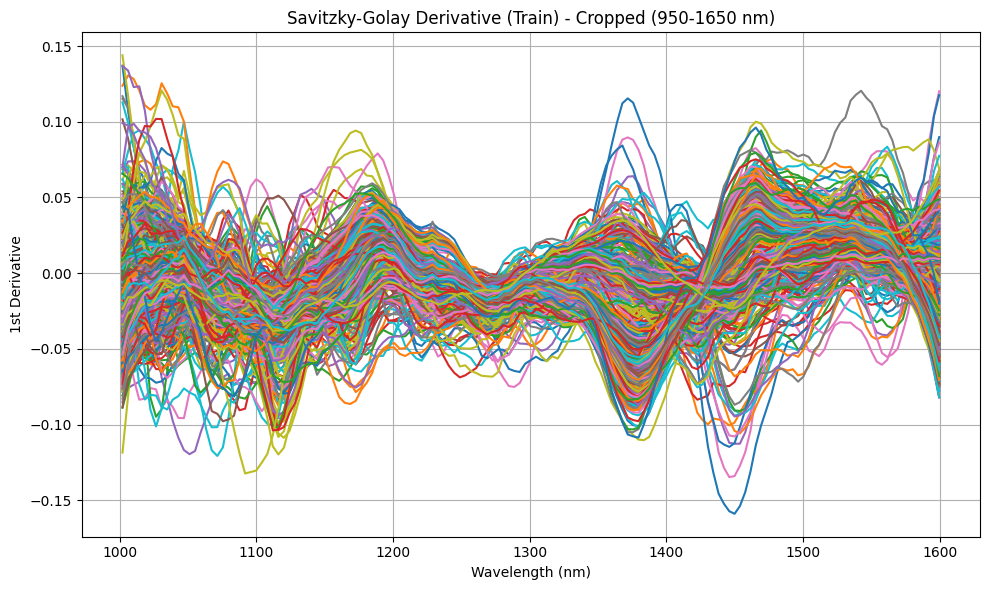

In [ ]:


# Recortar el espectro a la banda de 1000 a 1600 nm
# Identificar las columnas de longitud de onda dentro del rango deseado
wavelength_cols_cropped = [col for col in wavelength_cols if 1000 <= float(col.replace('wl_', '')) <= 1600]

# Crear nuevos dataframes con las longitudes de onda recortadas
train_df_sg_cropped = train_df_sg[['espectro_id', 'muestra', 'punto', 'medicion_id', 'archivo_original'] + wavelength_cols_cropped].copy()
test_df_sg_cropped = test_df_sg[['espectro_id', 'muestra', 'punto', 'medicion_id', 'archivo_original'] + wavelength_cols_cropped].copy()
vali_df_sg_cropped = vali_df_sg[['espectro_id', 'muestra', 'punto', 'medicion_id', 'archivo_original'] + wavelength_cols_cropped].copy()

print("\n📊 Datos recortados a la banda 1000-1600 nm:")
print(f"   Train recortado: {train_df_sg_cropped.shape[0]} espectros x {train_df_sg_cropped.shape[1]} columnas")
print(f"   Validation recortado: {vali_df_sg_cropped.shape[0]} espectros x {vali_df_sg_cropped.shape[1]} columnas")
print(f"   Test recortado: {test_df_sg_cropped.shape[0]} espectros x {test_df_sg_cropped.shape[1]} columnas")

# Mostrar una muestra de los datos recortados
print("\n🔍 Muestra de datos recortados (primeras 5 filas):")
display(train_df_sg_cropped.head())


# Opcional: Visualizar los espectros recortados
wavelengths_cropped = [float(col.replace('wl_', '')) for col in wavelength_cols_cropped]

plt.figure(figsize=(10, 6))

# Plot Savitzky-Golay Derivative Spectra (Examples from train set after cropping)
example_spectrum_ids_train_sg_cropped = train_df_sg_cropped['espectro_id'].sample(1000, random_state=42).tolist()
for spec_id in example_spectrum_ids_train_sg_cropped:
    if spec_id in train_df_sg_cropped['espectro_id'].values:
        spectrum_data_sg_cropped = train_df_sg_cropped[train_df_sg_cropped['espectro_id'] == spec_id][wavelength_cols_cropped].iloc[0].values
        plt.plot(wavelengths_cropped, spectrum_data_sg_cropped, label=spec_id)

plt.title('Savitzky-Golay Derivative (Train) - Cropped (950-1650 nm)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('1st Derivative')
plt.grid(True)
# plt.legend() # Opcional: Mostrar leyenda si son pocos espectros

plt.tight_layout()
plt.show()


# **Aplicar PCA a los especctros tratados**

In [ ]:


from sklearn.decomposition import PCA

# Seleccionar solo el spectral columns for PCA
X_train_sg = train_df_sg[wavelenght_cols_train]
X_vali_sg = vali_df_sg[wavelenght_cols_vali]
X_test_sg = test_df_sg[wavelenght_cols_test]

# Aplicar PCA al conjunto de entrenamiento
# Inicializar PCA sin especificar n_components para calcular la varianza explicada por cada componente
pca = PCA()
pca.fit(X_train_sg)

# Calcular la varianza acumulada
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)

# Encontrar el número de componentes que acumulan más del 95% de la varianza
n_components_95 = np.argmax(explained_variance_ratio_cumsum >= 0.95) + 1 # +1 porque argmax devuelve el índice (0-based)

print(f"\n📊 Aplicando PCA:")
print(f"   Varianza acumulada explicada por componente (primeros 10): {explained_variance_ratio_cumsum[:10]}")
print(f"   Número de componentes para >= 95% varianza: {n_components_95}")

# Volver a inicializar PCA con el número de componentes encontrados
pca_95 = PCA(n_components=n_components_95)

# Aplicar la transformación PCA a los conjuntos de train, validation y test
X_train_pca = pca_95.fit_transform(X_train_sg)
X_vali_pca = pca_95.transform(X_vali_sg)
X_test_pca = pca_95.transform(X_test_sg)

print(f"   Shape de los datos después de PCA (Train): {X_train_pca.shape}")
print(f"   Shape de los datos después de PCA (Validation): {X_vali_pca.shape}")
print(f"   Shape de los datos después de PCA (Test): {X_test_pca.shape}")

# Opcional: Convertir los resultados de PCA a DataFrames si necesitas mantener metadatos
# Crear nombres para las columnas de PCA
pca_cols = [f'PC{i+1}' for i in range(n_components_95)]

train_df_pca = pd.DataFrame(X_train_pca, columns=pca_cols, index=train_df_sg.index)
vali_df_pca = pd.DataFrame(X_vali_pca, columns=pca_cols, index=vali_df_sg.index)
test_df_pca = pd.DataFrame(X_test_pca, columns=pca_cols, index=test_df_sg.index)

# Concatenar con las columnas originales que no son espectrales
# Asegúrate de no incluir las columnas 'wl_' originales aquí, solo los metadatos
metadata_cols = [col for col in train_df_sg.columns if not col.startswith('wl_')]

train_df_pca = pd.concat([train_df_sg[metadata_cols], train_df_pca], axis=1)
vali_df_pca = pd.concat([vali_df_sg[metadata_cols], vali_df_pca], axis=1)
test_df_pca = pd.concat([test_df_sg[metadata_cols], test_df_pca], axis=1)


print("\n✅ PCA aplicado y DataFrames actualizados:")
display(train_df_pca.head())
display(vali_df_pca.head())
display(test_df_pca.head())



📊 Aplicando PCA:
   Varianza acumulada explicada por componente (primeros 10): [0.6166681  0.78296091 0.92632361 0.96103289 0.97777632 0.98233572
 0.98583783 0.98857495 0.99086138 0.99262178]
   Número de componentes para >= 95% varianza: 4
   Shape de los datos después de PCA (Train): (7740, 4)
   Shape de los datos después de PCA (Validation): (1935, 4)
   Shape de los datos después de PCA (Test): (3225, 4)

✅ PCA aplicado y DataFrames actualizados:


,espectro_id,muestra,punto,medicion_id,archivo_original,PC1,PC2,PC3,PC4
947,12_A_51,12,A,51,M12H-A.xlsx,-0.560351,-0.329998,0.652678,-0.095879
9969,32_C_71,32,C,71,M32H-C.xlsx,0.050493,0.077147,-0.111304,0.092865
11780,7_A_81,7,A,81,M7H-A.xlsx,-1.071675,-0.134139,-0.159375,-0.024737
1280,12_D_81,12,D,81,M12H-D.xlsx,-0.302752,-0.071599,0.763638,0.010492
122,10_B_29,10,B,29,M10H-B.xlsx,1.436094,-1.358367,-0.160521,-0.578592


,espectro_id,muestra,punto,medicion_id,archivo_original,PC1,PC2,PC3,PC4
7191,26_C_91,26,C,91,M26H-C.xlsx,0.511489,0.422707,-0.048929,0.030700
2948,17_A_52,17,A,52,M17H-A.xlsx,1.308137,0.052517,-0.155725,-0.242882
5952,23_C_56,23,C,56,M23H-C.xlsx,1.021504,0.416681,-0.204030,-0.318642
6225,24_B_31,24,B,31,M24H-B.xlsx,0.665421,0.457634,-0.207490,-0.036262
3000,17_B_1,17,B,1,M17H-B.xlsx,0.464675,0.422457,-0.079655,-0.181741


,espectro_id,muestra,punto,medicion_id,archivo_original,PC1,PC2,PC3,PC4
1463,13_B_66,13,B,66,M13H-B.xlsx,-0.360492,-0.145032,0.468863,0.132617
10008,32_D_16,32,D,16,M32H-D.xlsx,0.001750,0.039786,-0.004554,0.102980
8072,28_D_74,28,D,74,M28H-D.xlsx,0.256916,0.311243,0.056703,0.028679
3065,17_B_68,17,B,68,M17H-B.xlsx,0.643152,0.360722,-0.190596,-0.203766
8268,29_B_70,29,B,70,M29H-B.xlsx,0.629369,0.157924,-0.154859,0.032495


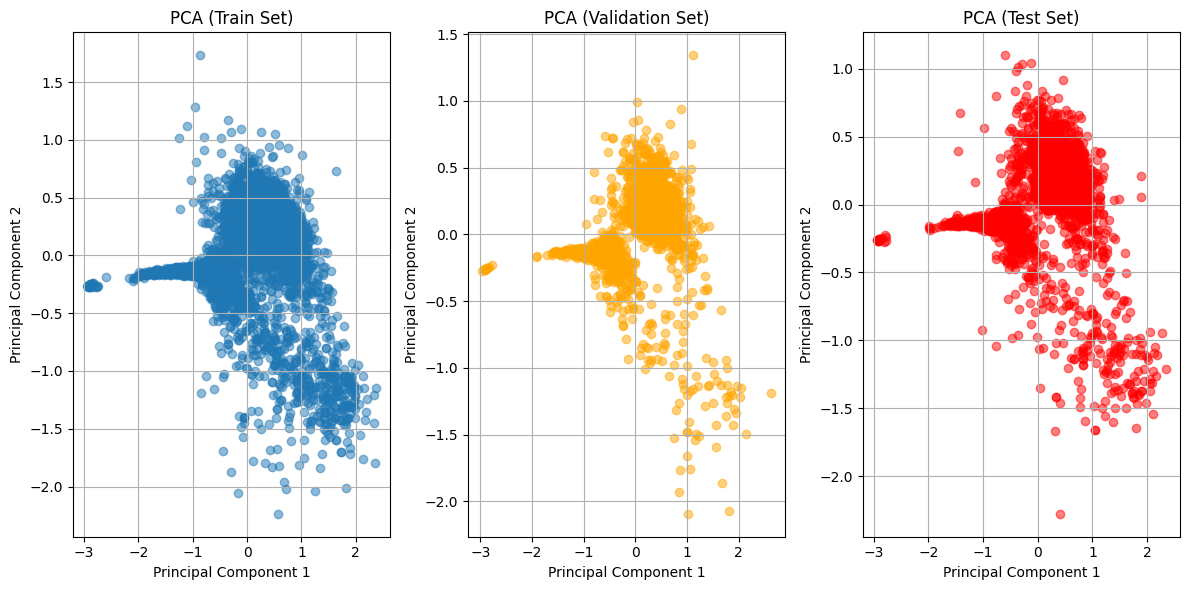

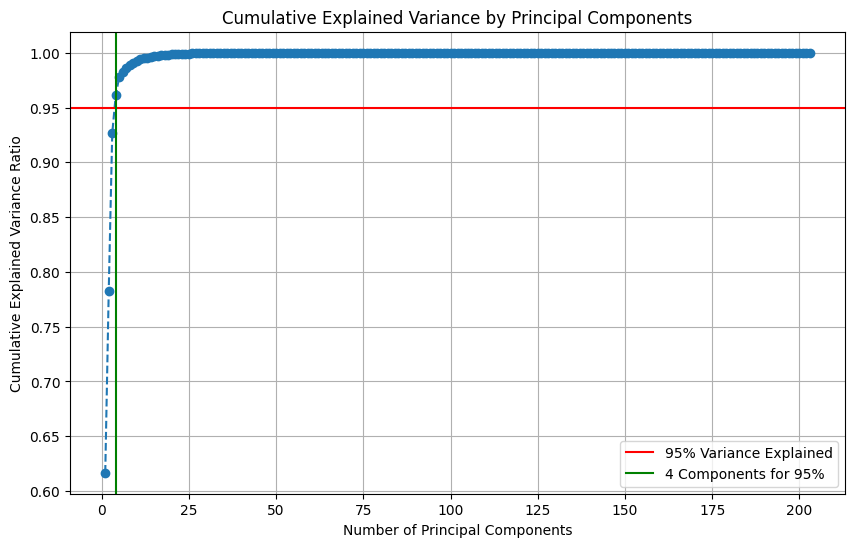

In [ ]:



plt.figure(figsize=(12, 6))

# Plot PC1 vs PC2 for the training set
plt.subplot(1, 3, 1)
plt.scatter(train_df_pca['PC1'], train_df_pca['PC2'], alpha=0.5)
plt.title('PCA (Train Set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Plot PC1 vs PC2 for the validation set
plt.subplot(1, 3, 2)
plt.scatter(vali_df_pca['PC1'], vali_df_pca['PC2'], alpha=0.5, color='orange')
plt.title('PCA (Validation Set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Plot PC1 vs PC2 for the test set
plt.subplot(1, 3, 3)
plt.scatter(test_df_pca['PC1'], test_df_pca['PC2'], alpha=0.5, color='red')
plt.title('PCA (Test Set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

plt.tight_layout()
plt.show()

#ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio_cumsum) + 1), explained_variance_ratio_cumsum, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance Explained')
plt.axvline(x=n_components_95, color='g', linestyle='-', label=f'{n_components_95} Components for 95%')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from scipy.spatial.distance import mahalanobis
import numpy as np

#  outlier detection
# Seleccionar solamente PCA component columns
pca_cols = [col for col in train_df_pca.columns if col.startswith('PC')]

X_pca_train = train_df_pca[pca_cols].values # Define X_pca_train
X_pca_vali = vali_df_pca[pca_cols].values # Define X_pca_vali
X_pca_test = test_df_pca[pca_cols].values # Define X_pca_test


# Asegurar training PCA data no esta vacio antes de procesar
if X_pca_train.shape[0] == 0 or X_pca_train.shape[1] == 0:
    print("Error: X_pca_train is empty. Cannot perform Mahalanobis distance calculation.")
else:
    # Calcular la media y covarianza de los pca
    mean_pca_train = np.mean(X_pca_train, axis=0)
    cov_pca_train = np.cov(X_pca_train.T)

    # Calcular la inversa y covarianza de la matriz
    # Añadir un valor pequeño (epsilon) a la  diagonal para numerical stability

    try:
        inv_cov_pca_train = np.linalg.inv(cov_pca_train)
    except np.linalg.LinAlgError:
        print("Error: Covariance matrix is singular. Cannot calculate inverse.")

        inv_cov_pca_train = np.linalg.inv(cov_pca_train + np.eye(cov_pca_train.shape[0]) * 1e-6)


    # Calcular Mahalanobis distancia para cada spectrum en el  training set
    distances_train = [mahalanobis(x, mean_pca_train, inv_cov_pca_train) for x in X_pca_train]

    # Define un outlier threshold basedo en el training data distribution
    threshold = np.percentile(distances_train, 95)
    outlier_mask_train = np.array(distances_train) > threshold

    print(f"\n📊 Outlier Detection Results (Mahalanobis Distance on PCA - Train Set):")
    print(f"   Total spectra analyzed: {X_pca_train.shape[0]}")
    print(f"   Mean of PCA components (Train): {mean_pca_train}")
    print(f"   Threshold (95th percentile of Train distances): {threshold:.4f}")
    print(f"   Number of potential outliers detected: {np.sum(outlier_mask_train)}")
    print(f"   Percentage of potential outliers: {(np.sum(outlier_mask_train) / X_pca_train.shape[0]) * 100:.2f}%")

    # Calcular Mahalanobis distancia para validation and test sets usando el  training mean y la inverse covariance
    if X_pca_vali.shape[0] > 0:
        distances_vali = [mahalanobis(x, mean_pca_train, inv_cov_pca_train) for x in X_pca_vali]
        outlier_mask_vali = np.array(distances_vali) > threshold
        print(f"\n📊 Outlier Detection Results (Mahalanobis Distance on PCA - Validation Set):")
        print(f"   Total spectra analyzed: {X_pca_vali.shape[0]}")
        print(f"   Number of potential outliers detected: {np.sum(outlier_mask_vali)}")
        print(f"   Percentage of potential outliers: {(np.sum(outlier_mask_vali) / X_pca_vali.shape[0]) * 100:.2f}%")
    else:
        print("\nℹ️ Validation set PCA data is empty. Skipping Mahalanobis distance calculation for validation.")


    if X_pca_test.shape[0] > 0:
        distances_test = [mahalanobis(x, mean_pca_train, inv_cov_pca_train) for x in X_pca_test]
        outlier_mask_test = np.array(distances_test) > threshold
        print(f"\n📊 Outlier Detection Results (Mahalanobis Distance on PCA - Test Set):")
        print(f"   Total spectra analyzed: {X_pca_test.shape[0]}")
        print(f"   Number of potential outliers detected: {np.sum(outlier_mask_test)}")
        print(f"   Percentage of potential outliers: {(np.sum(outlier_mask_test) / X_pca_test.shape[0]) * 100:.2f}%")
    else:
        print("\nℹ️ Test set PCA data is empty. Skipping Mahalanobis distance calculation for test.")




📊 Outlier Detection Results (Mahalanobis Distance on PCA - Train Set):
   Total spectra analyzed: 7740
   Mean of PCA components (Train): [ 8.44572761e-17 -1.65242497e-17 -1.00981526e-17  5.08923939e-17]
   Threshold (95th percentile of Train distances): 3.9541
   Number of potential outliers detected: 387
   Percentage of potential outliers: 5.00%

📊 Outlier Detection Results (Mahalanobis Distance on PCA - Validation Set):
   Total spectra analyzed: 1935
   Number of potential outliers detected: 78
   Percentage of potential outliers: 4.03%

📊 Outlier Detection Results (Mahalanobis Distance on PCA - Test Set):
   Total spectra analyzed: 3225
   Number of potential outliers detected: 159
   Percentage of potential outliers: 4.93%


In [ ]:


# Remover outliers de el train_df_pca DataFrame
if 'outlier_mask_train' in locals() and len(outlier_mask_train) == len(train_df_pca):
    train_df_pca_clean = train_df_pca[~outlier_mask_train].reset_index(drop=True)
    print(f"\n📊 Outliers removed from train_df_pca:")
    print(f"   Original shape: {train_df_pca.shape}")
    print(f"   Cleaned shape: {train_df_pca_clean.shape}")
else:
    print("\nError: outlier_mask_train not found or its length does not match train_df_pca. Cannot remove outliers from train set.")
    train_df_pca_clean = train_df_pca.copy() # mantener el original sino se puede remover

# Remover outliers de la vali_df_pca DataFrame
if 'outlier_mask_vali' in locals() and len(outlier_mask_vali) == len(vali_df_pca):
    vali_df_pca_clean = vali_df_pca[~outlier_mask_vali].reset_index(drop=True)
    print(f"\n📊 Outliers removed from vali_df_pca:")
    print(f"   Original shape: {vali_df_pca.shape}")
    print(f"   Cleaned shape: {vali_df_pca_clean.shape}")
else:
    print("\nError: outlier_mask_vali not found or its length does not match vali_df_pca. Cannot remove outliers from validation set.")
    vali_df_pca_clean = vali_df_pca.copy() # mantener el original sino se puede remover

# Remove outliers de el  test_df_pca DataFrame
if 'outlier_mask_test' in locals() and len(outlier_mask_test) == len(test_df_pca):
    test_df_pca_clean = test_df_pca[~outlier_mask_test].reset_index(drop=True)
    print(f"\n📊 Outliers removed from test_df_pca:")
    print(f"   Original shape: {test_df_pca.shape}")
    print(f"   Cleaned shape: {test_df_pca_clean.shape}")
else:
    print("\nError: outlier_mask_test not found or its length does not match test_df_pca. Cannot remove outliers from test set.")
    test_df_pca_clean = test_df_pca.copy() # mantener el original sino se puede remover

print("\n✅ Outlier removal process completed for train, validation, and test sets.")
display(train_df_pca_clean.head())
display(vali_df_pca_clean.head())
display(test_df_pca_clean.head())


📊 Outliers removed from train_df_pca:
   Original shape: (7740, 9)
   Cleaned shape: (7353, 9)

📊 Outliers removed from vali_df_pca:
   Original shape: (1935, 9)
   Cleaned shape: (1857, 9)

📊 Outliers removed from test_df_pca:
   Original shape: (3225, 9)
   Cleaned shape: (3066, 9)

✅ Outlier removal process completed for train, validation, and test sets.


,espectro_id,muestra,punto,medicion_id,archivo_original,PC1,PC2,PC3,PC4
0,12_A_51,12,A,51,M12H-A.xlsx,-0.560351,-0.329998,0.652678,-0.095879
1,32_C_71,32,C,71,M32H-C.xlsx,0.050493,0.077147,-0.111304,0.092865
2,7_A_81,7,A,81,M7H-A.xlsx,-1.071675,-0.134139,-0.159375,-0.024737
3,12_D_81,12,D,81,M12H-D.xlsx,-0.302752,-0.071599,0.763638,0.010492
4,1_C_69,1,C,69,M1H-C.xlsx,-0.560892,-0.082620,0.081116,0.141291


,espectro_id,muestra,punto,medicion_id,archivo_original,PC1,PC2,PC3,PC4
0,26_C_91,26,C,91,M26H-C.xlsx,0.511489,0.422707,-0.048929,0.030700
1,17_A_52,17,A,52,M17H-A.xlsx,1.308137,0.052517,-0.155725,-0.242882
2,23_C_56,23,C,56,M23H-C.xlsx,1.021504,0.416681,-0.204030,-0.318642
3,24_B_31,24,B,31,M24H-B.xlsx,0.665421,0.457634,-0.207490,-0.036262
4,17_B_1,17,B,1,M17H-B.xlsx,0.464675,0.422457,-0.079655,-0.181741


,espectro_id,muestra,punto,medicion_id,archivo_original,PC1,PC2,PC3,PC4
0,13_B_66,13,B,66,M13H-B.xlsx,-0.360492,-0.145032,0.468863,0.132617
1,32_D_16,32,D,16,M32H-D.xlsx,0.001750,0.039786,-0.004554,0.102980
2,28_D_74,28,D,74,M28H-D.xlsx,0.256916,0.311243,0.056703,0.028679
3,17_B_68,17,B,68,M17H-B.xlsx,0.643152,0.360722,-0.190596,-0.203766
4,29_B_70,29,B,70,M29H-B.xlsx,0.629369,0.157924,-0.154859,0.032495


Cargar el porcentaje de la materia seca




In [ ]:
# carga el archivo del drive en la tercera hoja
dmc_file_path = '/content/drive/MyDrive/Verano_delfin/Avance_data/NUEVA DATA/Copia de Peso palta materia seca.xlsx'
df_dmc = pd.read_excel(dmc_file_path, sheet_name= 3) # sheet_name=2 refers to the third sheet (0-indexed)


print("DMC data cargada correctamente.")
display(df_dmc.head())
display(df_dmc.info())

DMC data cargada correctamente.


,MUESTRA,Aluminiio (g),AL + Materia Fresca (g),AL + Materia seca (g),Solo materia fresca,Solo materia seca,TOTAL DMC %
0,M1H - 1,0.170,10.171,2.615,10.001,2.445,24.447555
1,M1H - 2,0.263,10.187,2.751,9.924,2.488,25.070536
2,M1H - 3,0.246,10.611,2.709,10.365,2.463,23.762663
3,M1H - 4,0.263,10.696,2.935,10.433,2.672,25.611042
4,M2H - 1,0.231,10.497,2.986,10.266,2.755,26.836158


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MUESTRA                  128 non-null    object 
 1   Aluminiio (g)            128 non-null    float64
 2   AL + Materia Fresca (g)  128 non-null    float64
 3   AL + Materia seca (g)    128 non-null    float64
 4   Solo materia fresca      128 non-null    float64
 5   Solo materia seca        128 non-null    float64
 6   TOTAL DMC %              128 non-null    float64
dtypes: float64(6), object(1)
memory usage: 7.1+ KB


None

**Dar formato a df de DMC% **

In [ ]:
import re

##Unicamente tomar la muestra y el % de DMC
df_p_dmc = df_dmc[['MUESTRA','TOTAL DMC %']].copy() # Create a copy to avoid SettingWithCopyWarning

# Extract numeric sample ID from 'MUESTRA' column
df_p_dmc['muestra'] = df_p_dmc['MUESTRA'].apply(lambda x: int(re.search(r'\d+', x).group(0)) if re.search(r'\d+', x) else None)

# Drop rows where 'muestra' could not be extracted (optional, depending on data quality)
df_p_dmc.dropna(subset=['muestra'], inplace=True)

# Convert 'muestra' column to integer type
df_p_dmc['muestra'] = df_p_dmc['muestra'].astype(int)

print("DMC data loaded and processed successfully.")
display(df_p_dmc.head())
display(df_p_dmc.info())

DMC data loaded and processed successfully.


,MUESTRA,TOTAL DMC %,muestra
0,M1H - 1,24.447555,1
1,M1H - 2,25.070536,1
2,M1H - 3,23.762663,1
3,M1H - 4,25.611042,1
4,M2H - 1,26.836158,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MUESTRA      128 non-null    object 
 1   TOTAL DMC %  128 non-null    float64
 2   muestra      128 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ KB


None

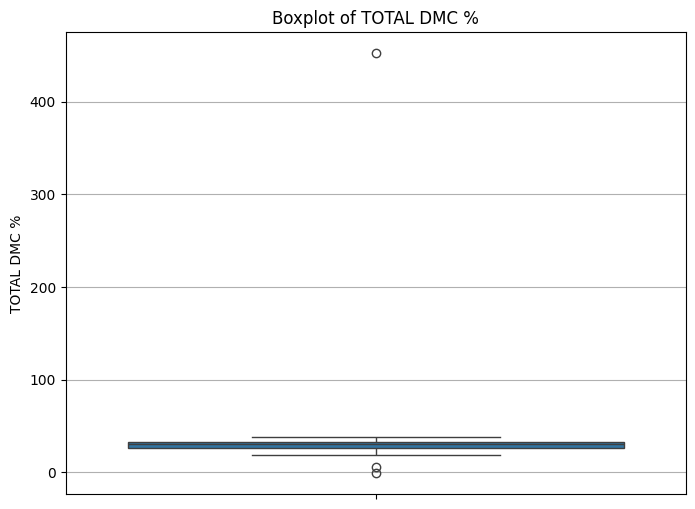

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a boxplot of the 'TOTAL DMC %' column
plt.figure(figsize=(8, 6)) # Optional: Adjust figure size
sns.boxplot(y=df_p_dmc['TOTAL DMC %'])  # Specify the column to plot
plt.title('Boxplot of TOTAL DMC %') # Optional: Add a title
plt.ylabel('TOTAL DMC %') # Optional: Add a y-axis label
plt.grid(True, axis='y') # Optional: Add a grid on the y-axis
plt.show()

# Reemplazar los valores atipicos de la materia seca



📊 Replacing outliers in 'TOTAL DMC %' column...
Replaced 3 outliers in column 'TOTAL DMC %' with the mean (29.41).

🔍 Data after replacing outliers:


,MUESTRA,TOTAL DMC %,muestra
0,M1H - 1,24.447555,1
1,M1H - 2,25.070536,1
2,M1H - 3,23.762663,1
3,M1H - 4,25.611042,1
4,M2H - 1,26.836158,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MUESTRA      128 non-null    object 
 1   TOTAL DMC %  128 non-null    float64
 2   muestra      128 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ KB


None

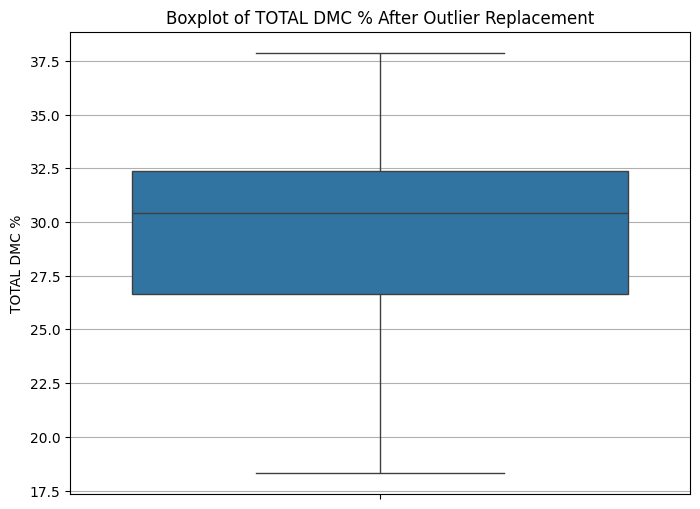

In [ ]:


# Function to replace outliers with the mean of the column
def replace_outliers_with_mean(df, column):
    """
    Replaces outliers in a specified column of a DataFrame with the mean of that column.
    Outliers are identified using the IQR method.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column to process for outliers.

    Returns:
        pd.DataFrame: The DataFrame with outliers replaced by the mean in the specified column.
                      Returns the original DataFrame if the column does not exist or has no numeric data.
    """
    if column not in df.columns:
        print(f"Warning: Column '{column}' not found in DataFrame.")
        return df

    if not pd.api.types.is_numeric_dtype(df[column]):
         print(f"Warning: Column '{column}' is not numeric. Skipping outlier replacement.")
         return df

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)

    # Calculate the mean of the non-outlier data
    mean_value = df[~outliers_mask][column].mean()

    # Replace outliers with the calculated mean
    df.loc[outliers_mask, column] = mean_value

    print(f"Replaced {outliers_mask.sum()} outliers in column '{column}' with the mean ({mean_value:.2f}).")

    return df

# Apply the function to the 'TOTAL DMC %' column
if 'df_p_dmc' in locals():
    print("\n📊 Replacing outliers in 'TOTAL DMC %' column...")
    df_p_dmc_cleaned = replace_outliers_with_mean(df_p_dmc.copy(), 'TOTAL DMC %')

    # Display the cleaned data and check the boxplot again
    print("\n🔍 Data after replacing outliers:")
    display(df_p_dmc_cleaned.head())
    display(df_p_dmc_cleaned.info())

    # Plot a boxplot of the 'TOTAL DMC %' column after cleaning
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df_p_dmc_cleaned['TOTAL DMC %'])
    plt.title('Boxplot of TOTAL DMC % After Outlier Replacement')
    plt.ylabel('TOTAL DMC %')
    plt.grid(True, axis='y')
    plt.show()

else:
    print("\nError: df_p_dmc DataFrame not found. Cannot replace outliers.")



# Machine learning


🔄 Merging PCA and DMC data...
✅ Data merging complete.
   Train merged shape: (29412, 10)
   Validation merged shape: (7428, 10)
   Test merged shape: (12264, 10)


,espectro_id,muestra,punto,medicion_id,archivo_original,PC1,PC2,PC3,PC4,TOTAL DMC %
0,12_A_51,12,A,51,M12H-A.xlsx,-0.560351,-0.329998,0.652678,-0.095879,32.128896
1,12_A_51,12,A,51,M12H-A.xlsx,-0.560351,-0.329998,0.652678,-0.095879,32.670807
2,12_A_51,12,A,51,M12H-A.xlsx,-0.560351,-0.329998,0.652678,-0.095879,33.858801
3,12_A_51,12,A,51,M12H-A.xlsx,-0.560351,-0.329998,0.652678,-0.095879,33.236771
4,32_C_71,32,C,71,M32H-C.xlsx,0.050493,0.077147,-0.111304,0.092865,29.784628



📊 Data prepared for MLP:
   X_train shape: (29412, 4), y_train shape: (29412,)
   X_vali shape: (7428, 4), y_vali shape: (7428,)
   X_test shape: (12264, 4), y_test shape: (12264,)

🧠 MLP Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433 (9.50 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)


🏋️ Training the MLP model...
Epoch 1/100
916/920 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 367.5368 - mae: 15.3935

920/920 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 366.3565 - mae: 15.3565 - val_loss: 12.9805 - val_mae: 2.7742
Epoch 2/100
915/920 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 35.3682 - mae: 4.6934

920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 35.3621 - mae: 4.6930 - val_loss: 12.4117 - val_mae: 2.7850
Epoch 3/100
915/920 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 33.9100 - mae: 4.5968

920/920 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 33.9053 - mae: 4.5965 - val_loss: 11.3084 - val_mae: 2.6066
Epoch 4/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 32.1209 - mae: 4.4852 - val_loss: 11.4168 - val_mae: 2.6275
Epoch 5/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 29.2736 - mae: 4.2701 - val_loss: 11.8313 - val_mae: 2.6839
Epoch 6/100
913/920 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.1627 - mae: 4.2018

920/920 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 28.1615 - mae: 4.2017 - val_loss: 10.6178 - val_mae: 2.4722
Epoch 7/100
918/920 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 27.3144 - mae: 4.1416

920/920 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 27.3140 - mae: 4.1415 - val_loss: 10.3960 - val_mae: 2.5060
Epoch 8/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 26.5238 - mae: 4.0850 - val_loss: 10.6086 - val_mae: 2.5130
Epoch 9/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 25.8873 - mae: 4.0037

920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 25.8872 - mae: 4.0037 - val_loss: 9.9811 - val_mae: 2.4341
Epoch 10/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24.6326 - mae: 3.9318

920/920 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 24.6324 - mae: 3.9318 - val_loss: 9.9796 - val_mae: 2.4323
Epoch 11/100
912/920 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23.8993 - mae: 3.8429

920/920 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 23.8966 - mae: 3.8428 - val_loss: 9.6160 - val_mae: 2.3720
Epoch 12/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - loss: 23.2117 - mae: 3.8077 - val_loss: 9.7145 - val_mae: 2.3984
Epoch 13/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 21.9583 - mae: 3.7172 - val_loss: 10.0839 - val_mae: 2.4608
Epoch 14/100
918/920 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.6912 - mae: 3.6560

920/920 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 21.6912 - mae: 3.6560 - val_loss: 9.3440 - val_mae: 2.3455
Epoch 15/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 20.8395 - mae: 3.6084 - val_loss: 9.3584 - val_mae: 2.3591
Epoch 16/100
909/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.3420 - mae: 3.5544

920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 20.3404 - mae: 3.5542 - val_loss: 8.9108 - val_mae: 2.2961
Epoch 17/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 20.1526 - mae: 3.5298 - val_loss: 9.3359 - val_mae: 2.3620
Epoch 18/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 19.2707 - mae: 3.4640 - val_loss: 9.5118 - val_mae: 2.3911
Epoch 19/100
917/920 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.0324 - mae: 3.4375

920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 19.0324 - mae: 3.4374 - val_loss: 8.8627 - val_mae: 2.3009
Epoch 20/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 18.2935 - mae: 3.3621 - val_loss: 8.8950 - val_mae: 2.2925
Epoch 21/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 18.3117 - mae: 3.3646 - val_loss: 9.2478 - val_mae: 2.3400
Epoch 22/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.6326 - mae: 3.2938

920/920 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 17.6324 - mae: 3.2938 - val_loss: 8.7027 - val_mae: 2.2469
Epoch 23/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 18.1060 - mae: 3.3265 - val_loss: 8.7228 - val_mae: 2.2451
Epoch 24/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 17.7131 - mae: 3.2829 - val_loss: 8.7305 - val_mae: 2.2709
Epoch 25/100
915/920 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.8462 - mae: 3.2107

920/920 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 16.8461 - mae: 3.2107 - val_loss: 8.5802 - val_mae: 2.2518
Epoch 26/100
910/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.5169 - mae: 3.1752

920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 16.5159 - mae: 3.1752 - val_loss: 8.5095 - val_mae: 2.2236
Epoch 27/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 16.1450 - mae: 3.1486 - val_loss: 8.5732 - val_mae: 2.2255
Epoch 28/100
918/920 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.1907 - mae: 3.1322

920/920 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 16.1901 - mae: 3.1321 - val_loss: 8.4326 - val_mae: 2.2053
Epoch 29/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 15.9942 - mae: 3.1110 - val_loss: 8.4475 - val_mae: 2.2035
Epoch 30/100
916/920 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.1955 - mae: 3.0340

920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 15.1947 - mae: 3.0339 - val_loss: 8.4262 - val_mae: 2.1944
Epoch 31/100
918/920 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.1868 - mae: 3.0289

920/920 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 15.1862 - mae: 3.0288 - val_loss: 8.3994 - val_mae: 2.1930
Epoch 32/100
918/920 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.5283 - mae: 2.9693

920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 14.5288 - mae: 2.9693 - val_loss: 8.3688 - val_mae: 2.1957
Epoch 33/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 14.5302 - mae: 2.9642 - val_loss: 8.5575 - val_mae: 2.2231
Epoch 34/100
912/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.2518 - mae: 2.9263

920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 14.2513 - mae: 2.9263 - val_loss: 8.1539 - val_mae: 2.1685
Epoch 35/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 13.7249 - mae: 2.8760 - val_loss: 8.3147 - val_mae: 2.1743
Epoch 36/100
913/920 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.6244 - mae: 2.8609

920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 13.6239 - mae: 2.8608 - val_loss: 8.0577 - val_mae: 2.1141
Epoch 37/100
910/920 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.5657 - mae: 2.8495

920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 13.5643 - mae: 2.8493 - val_loss: 8.0182 - val_mae: 2.1225
Epoch 38/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 13.4708 - mae: 2.8281 - val_loss: 8.2014 - val_mae: 2.1702
Epoch 39/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 12.9373 - mae: 2.7768 - val_loss: 8.0384 - val_mae: 2.1436
Epoch 40/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 12.6312 - mae: 2.7304 - val_loss: 8.0907 - val_mae: 2.1399
Epoch 41/100
913/920 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.4972 - mae: 2.7254

920/920 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 12.4976 - mae: 2.7254 - val_loss: 7.9839 - val_mae: 2.1405
Epoch 42/100
912/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.3483 - mae: 2.7079

920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 12.3474 - mae: 2.7078 - val_loss: 7.9238 - val_mae: 2.1290
Epoch 43/100
914/920 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.0629 - mae: 2.6746

920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 12.0625 - mae: 2.6745 - val_loss: 7.9008 - val_mae: 2.1043
Epoch 44/100
915/920 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.7920 - mae: 2.6466

920/920 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 11.7921 - mae: 2.6465 - val_loss: 7.8318 - val_mae: 2.0979
Epoch 45/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 11.9264 - mae: 2.6508 - val_loss: 7.9651 - val_mae: 2.1238
Epoch 46/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 11.6329 - mae: 2.6071 - val_loss: 7.8435 - val_mae: 2.1022
Epoch 47/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 11.5839 - mae: 2.6051 - val_loss: 7.8630 - val_mae: 2.1123
Epoch 48/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 11.2053 - mae: 2.5634 - val_loss: 8.0106 - val_mae: 2.1183
Epoch 49/100
919/920 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.4437 - mae: 2.5762

920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 11.4436 - mae: 2.5762 - val_loss: 7.8061 - val_mae: 2.0923
Epoch 50/100
914/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.2760 - mae: 2.5670

920/920 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 11.2750 - mae: 2.5669 - val_loss: 7.7809 - val_mae: 2.0801
Epoch 51/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 11.0638 - mae: 2.5306 - val_loss: 7.8162 - val_mae: 2.0924
Epoch 52/100
915/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.7729 - mae: 2.5137

920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 10.7735 - mae: 2.5137 - val_loss: 7.7007 - val_mae: 2.0757
Epoch 53/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 10.7967 - mae: 2.5019 - val_loss: 7.7534 - val_mae: 2.0979
Epoch 54/100
915/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.7884 - mae: 2.5000

920/920 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 10.7877 - mae: 2.5000 - val_loss: 7.6981 - val_mae: 2.0643
Epoch 55/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 10.6394 - mae: 2.4901 - val_loss: 7.7550 - val_mae: 2.0811
Epoch 56/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 10.5631 - mae: 2.4894 - val_loss: 7.7408 - val_mae: 2.0782
Epoch 57/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.6082 - mae: 2.4830

920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 10.6080 - mae: 2.4830 - val_loss: 7.6959 - val_mae: 2.0829
Epoch 58/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 10.0023 - mae: 2.4046 - val_loss: 7.7091 - val_mae: 2.0913
Epoch 59/100
909/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.1467 - mae: 2.4306

920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 10.1478 - mae: 2.4306 - val_loss: 7.6728 - val_mae: 2.0802
Epoch 60/100
916/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.2919 - mae: 2.4447

920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 10.2912 - mae: 2.4446 - val_loss: 7.6599 - val_mae: 2.0900
Epoch 61/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.0721 - mae: 2.4223

920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 10.0721 - mae: 2.4223 - val_loss: 7.6482 - val_mae: 2.0754
Epoch 62/100
919/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9506 - mae: 2.4093

920/920 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 9.9505 - mae: 2.4093 - val_loss: 7.5784 - val_mae: 2.0642
Epoch 63/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 9.8164 - mae: 2.3824 - val_loss: 7.5863 - val_mae: 2.0721
Epoch 64/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 9.8388 - mae: 2.3836 - val_loss: 7.6348 - val_mae: 2.0871
Epoch 65/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 9.6321 - mae: 2.3643 - val_loss: 7.6284 - val_mae: 2.0810
Epoch 66/100
918/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.5837 - mae: 2.3606

920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 9.5836 - mae: 2.3605 - val_loss: 7.5295 - val_mae: 2.0589
Epoch 67/100
919/920 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.5006 - mae: 2.3408

920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 9.5008 - mae: 2.3408 - val_loss: 7.4798 - val_mae: 2.0422
Epoch 68/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 9.4918 - mae: 2.3393 - val_loss: 7.6326 - val_mae: 2.0714
Epoch 69/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 9.6012 - mae: 2.3630 - val_loss: 7.5212 - val_mae: 2.0481
Epoch 70/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 9.4563 - mae: 2.3219 - val_loss: 7.5172 - val_mae: 2.0582
Epoch 71/100
911/920 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2676 - mae: 2.3134

920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 9.2668 - mae: 2.3132 - val_loss: 7.4361 - val_mae: 2.0429
Epoch 72/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 9.1656 - mae: 2.2861 - val_loss: 7.4468 - val_mae: 2.0544
Epoch 73/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 9.0184 - mae: 2.2787 - val_loss: 7.4401 - val_mae: 2.0463
Epoch 74/100
914/920 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1487 - mae: 2.2926

920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 9.1475 - mae: 2.2924 - val_loss: 7.3970 - val_mae: 2.0307
Epoch 75/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 8.9722 - mae: 2.2734 - val_loss: 7.4630 - val_mae: 2.0408
Epoch 76/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 8.9983 - mae: 2.2764 - val_loss: 7.4620 - val_mae: 2.0441
Epoch 77/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 8.7832 - mae: 2.2337 - val_loss: 7.4184 - val_mae: 2.0276
Epoch 78/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 9.0053 - mae: 2.2716 - val_loss: 7.4463 - val_mae: 2.0318
Epoch 79/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 9.0321 - mae: 2.2644 - val_loss: 7.5211 - val_mae: 2.0397
Epoch 80/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 8.8554 - mae: 2.2465 - val_loss: 7.5197 - val_mae: 2.0423
Epoch 81/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 8.8347 - mae: 2.2372 - val_loss: 7.4599 - val_mae: 2.0385
Epoch 82/100
914/920 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 8.7277 - mae: 2.2250 - val_loss: 7.3927 - val_mae: 2.0187
Epoch 83/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 8.6899 - mae: 2.2120 - val_loss: 7.4263 - val_mae: 2.0352
Epoch 84/100
919/920 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6541 - mae: 2.2162

920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 8.6542 - mae: 2.2162 - val_loss: 7.3749 - val_mae: 2.0340
Epoch 85/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 8.6325 - mae: 2.2194 - val_loss: 7.4244 - val_mae: 2.0546
Epoch 86/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 8.5197 - mae: 2.2047 - val_loss: 7.4275 - val_mae: 2.0387
Epoch 87/100
908/920 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3974 - mae: 2.1851

920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 8.3999 - mae: 2.1854 - val_loss: 7.3135 - val_mae: 2.0230
Epoch 88/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 8.3620 - mae: 2.1789 - val_loss: 7.3548 - val_mae: 2.0153
Epoch 89/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 8.4820 - mae: 2.1946 - val_loss: 7.3465 - val_mae: 2.0243
Epoch 90/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 8.5043 - mae: 2.1997 - val_loss: 7.3286 - val_mae: 2.0157
Epoch 91/100
915/920 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5181 - mae: 2.1904

920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 8.5181 - mae: 2.1904 - val_loss: 7.2635 - val_mae: 2.0187
Epoch 92/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 8.5725 - mae: 2.1922 - val_loss: 7.3592 - val_mae: 2.0195
Epoch 93/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 8.5800 - mae: 2.1994 - val_loss: 7.3899 - val_mae: 2.0322
Epoch 94/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 8.5756 - mae: 2.2004 - val_loss: 7.3675 - val_mae: 2.0238
Epoch 95/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 8.5409 - mae: 2.1904 - val_loss: 7.2729 - val_mae: 2.0011
Epoch 96/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 8.3682 - mae: 2.1724 - val_loss: 7.3540 - val_mae: 2.0211
Epoch 97/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 8.5238 - mae: 2.1947 - val_loss: 7.3773 - val_mae: 2.0358
Epoch 98/100
920/920 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 8.4184 - mae: 2.1789 - val_loss: 7.2660 - val_mae: 2.0071
Epoch 99/100
910/920 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/st

920/920 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 8.3622 - mae: 2.1717 - val_loss: 7.1273 - val_mae: 1.9755
Epoch 100/100
916/920 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2373 - mae: 2.1481

920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 8.2376 - mae: 2.1481 - val_loss: 6.9914 - val_mae: 1.9556

✅ Training complete.

🔬 Evaluating the model on the test set...
   Test Loss (MSE): 7.5041
   Test MAE: 2.0148


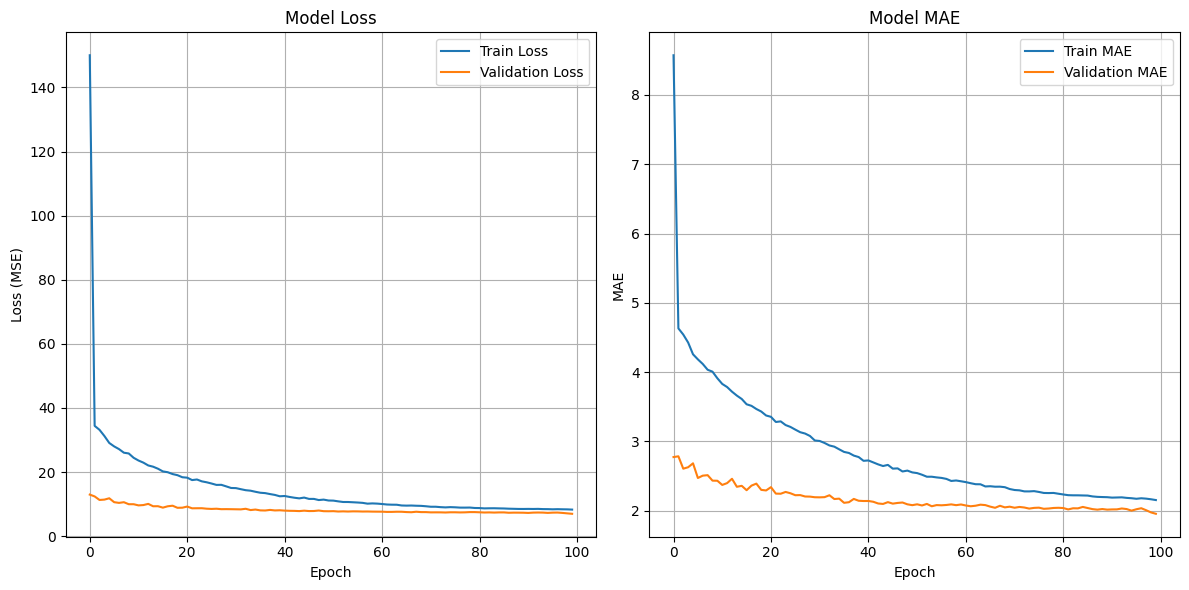

384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

📈 Sample Predictions vs Actual (Test Set):


,Actual DMC %,Predicted DMC %
0,31.028761,32.130116
1,32.577742,32.130116
2,34.561213,32.130116
3,33.122792,32.130116
4,29.784628,28.520252


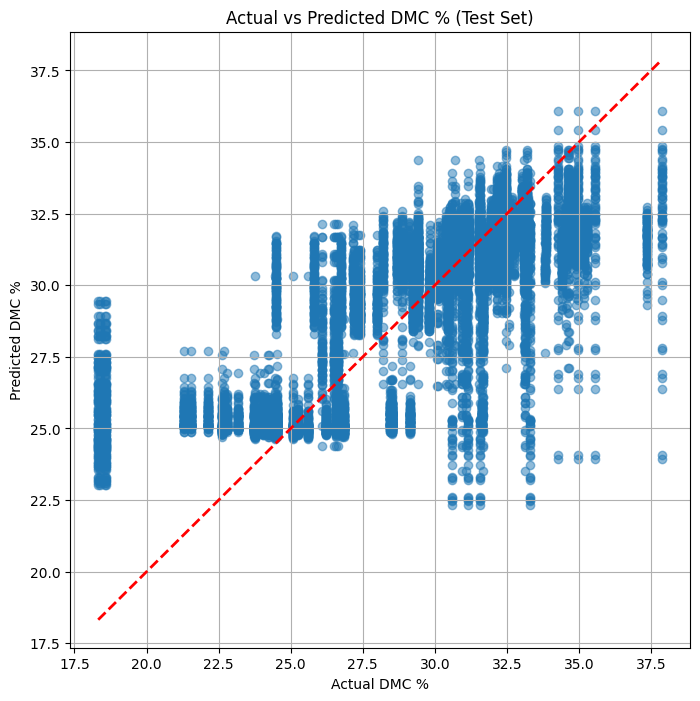

In [ ]:
# prompt: aplicar MLP MSE RMSE R2

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Select the PCA components for the features (X)
pca_cols = [col for col in train_df_pca_clean.columns if col.startswith('PC')]

X_train = train_df_pca_clean[pca_cols]
X_vali = vali_df_pca_clean[pca_cols]
X_test = test_df_pca_clean[pca_cols]

# Merge the PCA dataframes with the cleaned DMC data
# We need the 'muestra' column from the PCA dataframes to join with df_p_dmc_cleaned
# Ensure the join is on the 'muestra' column

# Add 'muestra' to X dataframes if not already there (should be from the concatenation step)
if 'muestra' not in X_train.columns:
    X_train = pd.merge(train_df_pca_clean[['espectro_id', 'muestra']], X_train, left_index=True, right_index=True, how='left')
    X_vali = pd.merge(vali_df_pca_clean[['espectro_id', 'muestra']], X_vali, left_index=True, right_index=True, how='left')
    X_test = pd.merge(test_df_pca_clean[['espectro_id', 'muestra']], X_test, left_index=True, right_index=True, how='left')


# Merge with the cleaned DMC data to get the target variable (y)
# Join the PCA dataframes with the df_p_dmc_cleaned dataframe on the 'muestra' column
train_merged = pd.merge(X_train, df_p_dmc_cleaned[['muestra', 'TOTAL DMC %']], on='muestra', how='left')
vali_merged = pd.merge(X_vali, df_p_dmc_cleaned[['muestra', 'TOTAL DMC %']], on='muestra', how='left')
test_merged = pd.merge(X_test, df_p_dmc_cleaned[['muestra', 'TOTAL DMC %']], on='muestra', how='left')

# Drop rows where DMC data was not found (NaN in 'TOTAL DMC %')
train_merged.dropna(subset=['TOTAL DMC %'], inplace=True)
vali_merged.dropna(subset=['TOTAL DMC %'], inplace=True)
test_merged.dropna(subset=['TOTAL DMC %'], inplace=True)

# Separate features (X) and target (y) after merging and handling NaNs
X_train_final = train_merged[pca_cols]
y_train = train_merged['TOTAL DMC %']

X_vali_final = vali_merged[pca_cols]
y_vali = vali_merged['TOTAL DMC %']

X_test_final = test_merged[pca_cols]
y_test = test_merged['TOTAL DMC %']


print("\n📊 Data ready for MLP Regressor:")
print(f"   Train shapes: X={X_train_final.shape}, y={y_train.shape}")
print(f"   Validation shapes: X={X_vali_final.shape}, y={y_vali.shape}")
print(f"   Test shapes: X={X_test_final.shape}, y={y_test.shape}")


# --- MLP Regressor ---

# Initialize the MLP Regressor model
# You might need to tune these parameters (hidden_layer_sizes, activation, solver, alpha, max_iter)
mlp = MLPRegressor(hidden_layer_sizes=(100, 50),  # Example: two hidden layers with 100 and 50 neurons
                   activation='relu',           # Activation function for the hidden layers
                   solver='adam',               # The solver for weight optimization
                   alpha=0.0001,                # L2 penalty (regularization term)
                   max_iter=500,                # Maximum number of iterations
                   random_state=42,             # For reproducibility
                   early_stopping=True,         # Stop training when validation score is not improving
                   validation_fraction=0.1,     # Proportion of training data to set aside for validation
                   n_iter_no_change=10)         # Number of iterations with no improvement to wait before stopping


print("\n🚀 Training MLP Regressor...")
# Train the model using the training data
mlp.fit(X_train_final, y_train)

print("✅ MLP Regressor training complete.")

# --- Evaluation ---

print("\n🔬 Evaluating MLP Regressor on Validation and Test sets:")

# Predict on the validation set
y_vali_pred = mlp.predict(X_vali_final)

# Calculate metrics on the validation set
mse_vali = mean_squared_error(y_vali, y_vali_pred)
rmse_vali = sqrt(mse_vali)
r2_vali = r2_score(y_vali, y_vali_pred)

print(f"   Validation Set:")
print(f"     MSE: {mse_vali:.4f}")
print(f"     RMSE: {rmse_vali:.4f}")
print(f"     R2 Score: {r2_vali:.4f}")

# Predict on the test set
y_test_pred = mlp.predict(X_test_final)

# Calculate metrics on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"   Test Set:")
print(f"     MSE: {mse_test:.4f}")
print(f"     RMSE: {rmse_test:.4f}")
print(f"     R2 Score: {r2_test:.4f}")

# Optional: Plotting actual vs predicted values for the test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel("Actual TOTAL DMC %")
plt.ylabel("Predicted TOTAL DMC %")
plt.title("Actual vs Predicted TOTAL DMC % (MLP - Test Set)")
plt.grid(True)
plt.show()

# Optional: Plotting residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel("Predicted TOTAL DMC %")
plt.ylabel("Residuals")
plt.title("Residual Plot (MLP - Test Set)")
plt.grid(True)
plt.show()



📊 Data prepared for MLP Cross-Validation:
   X_train_final shape: (29412, 4), y_train shape: (29412,)
   X_vali_final shape: (7428, 4), y_vali shape: (7428,)
   X_test_final shape: (12264, 4), y_test_final shape: (12264,)

🔄 Performing Cross-Validation on combined Train + Validation data...
   Shape of combined data: X=(36840, 4), y=(36840,)

--- Fold 1 ---
   Training fold 1...
   Training for fold 1 complete.
   Fold 1 Metrics:
     MSE: 7.0347
     RMSE: 2.6523
     R2 Score: 0.5876

--- Fold 2 ---
   Training fold 2...
   Training for fold 2 complete.
   Fold 2 Metrics:
     MSE: 6.5435
     RMSE: 2.5580
     R2 Score: 0.6015

--- Fold 3 ---
   Training fold 3...
   Training for fold 3 complete.
   Fold 3 Metrics:
     MSE: 6.8803
     RMSE: 2.6230
     R2 Score: 0.5922

--- Fold 4 ---
   Training fold 4...
   Training for fold 4 complete.
   Fold 4 Metrics:
     MSE: 6.8264
     RMSE: 2.6127
     R2 Score: 0.5864

--- Fold 5 ---
   Training fold 5...
   Training for fold 5 comple

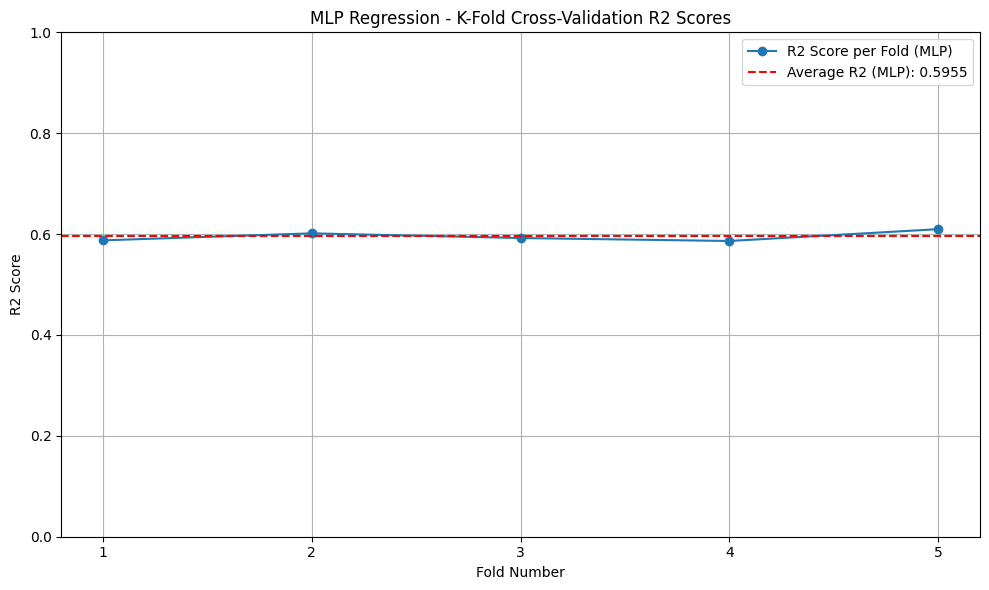

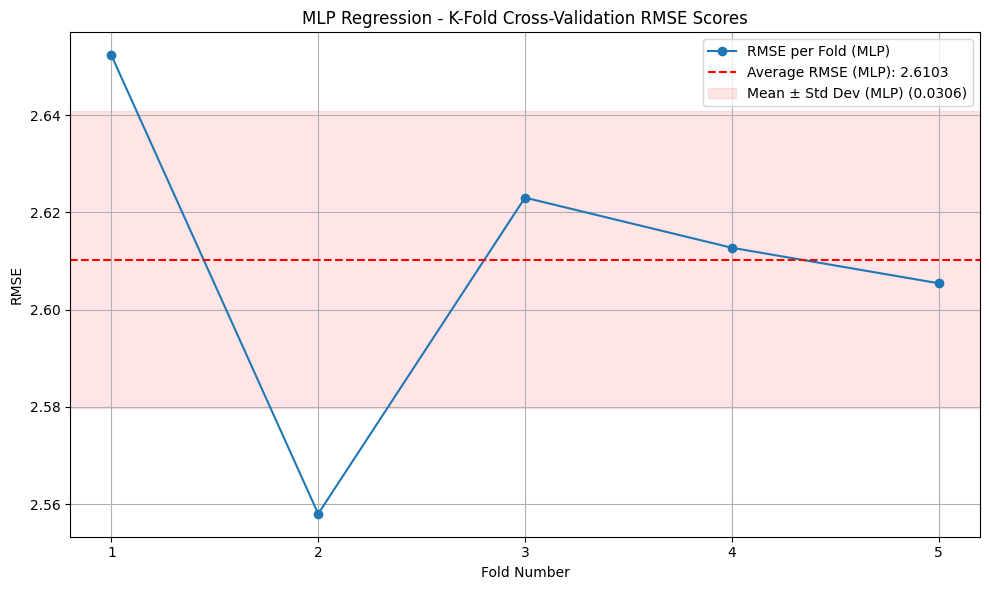


 retraining Final Model on combined train+validation data...
 Final Model training complete.

 Evaluating Final Model on independent Test Set...
   Final Model Test Set Metrics:
     MSE: 7.1380
     RMSE: 2.6717
     R2 Score: 0.5852


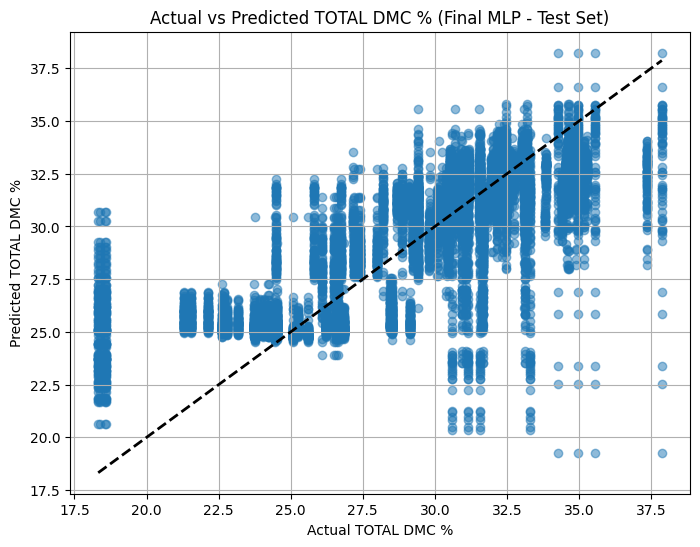

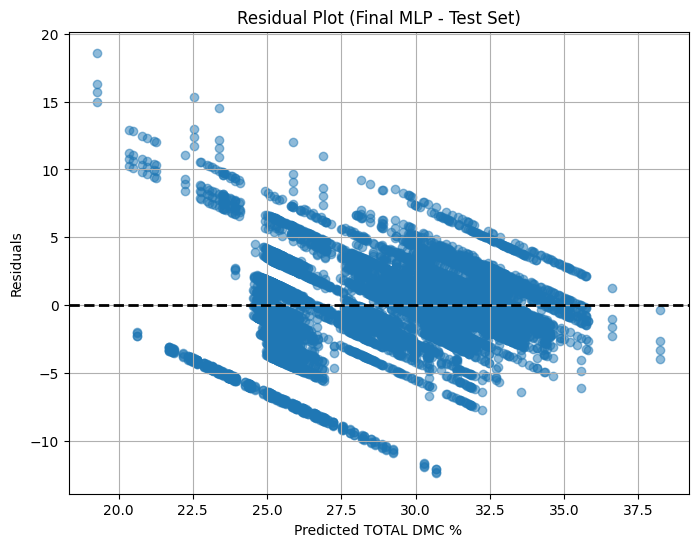

In [ ]:
# prompt: APLICAR VALIDACION CRUZADA

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd # Import pandas
import matplotlib.pyplot as plt # Import matplotlib


# --- Prepare the data for MLP Cross-Validation ---
# The features (X) and target variable (y) for the MLP model
# are derived from the cleaned PCA data merged with the DMC percentage data.
# We will perform this merging and variable definition within this cell
# to ensure the data is available for cross-validation.

# Ensure the necessary dataframes from previous steps are available
if 'train_df_pca_clean' not in locals() or 'vali_df_pca_clean' not in locals() or \
   'test_df_pca_clean' not in locals() or 'df_p_dmc_cleaned' not in locals():
    print("\nError: Required cleaned dataframes (train_df_pca_clean, vali_df_pca_clean, test_df_pca_clean, df_p_dmc_cleaned) are not available. Please run the data processing and cleaning steps first.")
else:
    # Identify PCA columns in the cleaned dataframes
    pca_cols = [col for col in train_df_pca_clean.columns if col.startswith('PC')] # Use clean dataframes

    # Merge the cleaned PCA dataframes with the DMC data
    # Ensure the merge is done correctly to align DMC with each spectrum based on 'muestra'
    train_df_merged_clean = pd.merge(train_df_pca_clean, df_p_dmc_cleaned[['muestra', 'TOTAL DMC %']], on='muestra', how='left')
    vali_df_merged_clean = pd.merge(vali_df_pca_clean, df_p_dmc_cleaned[['muestra', 'TOTAL DMC %']], on='muestra', how='left')
    test_df_merged_clean = pd.merge(test_df_pca_clean, df_p_dmc_cleaned[['muestra', 'TOTAL DMC %']], on='muestra', how='left')

    # Drop rows where DMC data is missing after merging with cleaned data
    train_df_merged_clean.dropna(subset=['TOTAL DMC %'], inplace=True)
    vali_df_merged_clean.dropna(subset=['TOTAL DMC %'], inplace=True)
    test_df_merged_clean.dropna(subset=['TOTAL DMC %'], inplace=True)

    # Reset index after dropping NaNs to ensure alignment for model training
    train_df_merged_clean.reset_index(drop=True, inplace=True)
    vali_df_merged_clean.reset_index(drop=True, inplace=True)
    test_df_merged_clean.reset_index(drop=True, inplace=True)

    # Define features (X) and target (y) from the cleaned, merged dataframes
    X_train_final = train_df_merged_clean[pca_cols]
    y_train = train_df_merged_clean['TOTAL DMC %']

    X_vali_final = vali_df_merged_clean[pca_cols]
    y_vali = vali_df_merged_clean['TOTAL DMC %']

    X_test_final = test_df_merged_clean[pca_cols]
    y_test_final = test_df_merged_clean['TOTAL DMC %'] # Renamed for clarity in final eval

    print("\n📊 Data prepared for MLP Cross-Validation:")
    print(f"   X_train_final shape: {X_train_final.shape}, y_train shape: {y_train.shape}")
    print(f"   X_vali_final shape: {X_vali_final.shape}, y_vali shape: {y_vali.shape}")
    print(f"   X_test_final shape: {X_test_final.shape}, y_test_final shape: {y_test_final.shape}")


    # Combine the training and validation data for cross-validation
    X_train_combined = pd.concat([X_train_final, X_vali_final], axis=0, ignore_index=True)
    y_train_combined = pd.concat([y_train, y_vali], axis=0, ignore_index=True)

    print("\n🔄 Performing Cross-Validation on combined Train + Validation data...")
    print(f"   Shape of combined data: X={X_train_combined.shape}, y={y_train_combined.shape}")

    # Initialize K-Fold Cross-Validation
    # n_splits: number of folds (e.g., 5 or 10)
    n_splits_mlp_cv = 5 # Number of folds
    kf = KFold(n_splits=n_splits_mlp_cv, shuffle=True, random_state=42)

    # Lists to store metrics for each fold
    mse_scores_mlp_cv = []
    rmse_scores_mlp_cv = []
    r2_scores_mlp_cv = []

    # Perform cross-validation
    fold = 1
    for train_index, val_index in kf.split(X_train_combined, y_train_combined): # Pass both X and y to kf.split
        print(f"\n--- Fold {fold} ---")

        # Split data into fold train and fold validation sets
        X_fold_train, X_fold_val = X_train_combined.iloc[train_index], X_train_combined.iloc[val_index]
        y_fold_train, y_fold_val = y_train_combined.iloc[train_index], y_train_combined.iloc[val_index]

        # Initialize a new MLP Regressor model for each fold
        # Use the same parameters as before, or tune them if needed
        from sklearn.neural_network import MLPRegressor # Import MLPRegressor here to ensure it's available
        mlp_fold = MLPRegressor(hidden_layer_sizes=(100, 50),
                                activation='relu',
                                solver='adam',
                                alpha=0.0001,
                                max_iter=500,
                                random_state=42, # Use a consistent random state or none if you want variation
                                early_stopping=True,
                                validation_fraction=0.1, # This validation fraction is used *within* the fold training
                                n_iter_no_change=10)

        # Train the model on the fold training data
        print(f"   Training fold {fold}...")
        mlp_fold.fit(X_fold_train, y_fold_train) # Corrected target variable to y_fold_train
        print(f"   Training for fold {fold} complete.")

        # Predict on the fold validation data
        y_fold_pred = mlp_fold.predict(X_fold_val)

        # Calculate metrics for the current fold
        mse_fold = mean_squared_error(y_fold_val, y_fold_pred)
        rmse_fold = sqrt(mse_fold)
        r2_fold = r2_score(y_fold_val, y_fold_pred)

        mse_scores_mlp_cv.append(mse_fold)
        rmse_scores_mlp_cv.append(rmse_fold)
        r2_scores_mlp_cv.append(r2_fold)

        print(f"   Fold {fold} Metrics:")
        print(f"     MSE: {mse_fold:.4f}")
        print(f"     RMSE: {rmse_fold:.4f}")
        print(f"     R2 Score: {r2_fold:.4f}")

        fold += 1

    # Report the average metrics across all folds
    print("\n✅ Cross-Validation Complete.")
    print(f"Average Metrics across {kf.n_splits} folds:")
    print(f"  Average MSE: {np.mean(mse_scores_mlp_cv):.4f} (+/- {np.std(mse_scores_mlp_cv):.4f})")
    print(f"  Average RMSE: {np.mean(rmse_scores_mlp_cv):.4f} (+/- {np.std(rmse_scores_mlp_cv):.4f})")
    print(f"  Average R2 Score: {np.mean(r2_scores_mlp_cv):.4f} (+/- {np.std(r2_scores_mlp_cv):.4f})")


    # Plotting the cross-validation results for MLP
    plt.figure(figsize=(10, 6))

    # Plot R2 scores for each fold
    plt.plot(range(1, n_splits_mlp_cv + 1), r2_scores_mlp_cv, marker='o', linestyle='-', label='R2 Score per Fold (MLP)')

    # Plot the average R2 score
    plt.axhline(y=np.mean(r2_scores_mlp_cv), color='r', linestyle='--', label=f'Average R2 (MLP): {np.mean(r2_scores_mlp_cv):.4f}')

    plt.title('MLP Regression - K-Fold Cross-Validation R2 Scores')
    plt.xlabel('Fold Number')
    plt.ylabel('R2 Score')
    plt.xticks(range(1, n_splits_mlp_cv + 1))
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot RMSE scores for each fold for MLP
    plt.figure(figsize=(10, 6))

    # Plot RMSE scores for each fold
    plt.plot(range(1, n_splits_mlp_cv + 1), rmse_scores_mlp_cv, marker='o', linestyle='-', label='RMSE per Fold (MLP)')

    # Plot the average RMSE score
    plt.axhline(y=np.mean(rmse_scores_mlp_cv), color='r', linestyle='--', label=f'Average RMSE (MLP): {np.mean(rmse_scores_mlp_cv):.4f}')
    plt.axhspan(np.mean(rmse_scores_mlp_cv) - np.std(rmse_scores_mlp_cv), np.mean(rmse_scores_mlp_cv) + np.std(rmse_scores_mlp_cv), color='r', alpha=0.1, label=f'Mean ± Std Dev (MLP) ({np.std(rmse_scores_mlp_cv):.4f})')


    plt.title('MLP Regression - K-Fold Cross-Validation RMSE Scores')
    plt.xlabel('Fold Number')
    plt.ylabel('RMSE')
    plt.xticks(range(1, n_splits_mlp_cv + 1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


    # The final model would typically be trained on the entire combined dataset (X_train_combined, y_train_combined)
    # after determining the best hyperparameters based on the cross-validation results.
    # Then, this final model is evaluated *once* on the independent test set (X_test_final, y_test_final).

    # Optional: Train the final model on the full combined training/validation data
    print("\n retraining Final Model on combined train+validation data...")
    final_mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50),
                                   activation='relu',
                                   solver='adam',
                                   alpha=0.0001,
                                   max_iter=500,
                                   random_state=42,
                                   early_stopping=True,
                                   validation_fraction=0.1,
                                   n_iter_no_change=10)

    final_mlp_model.fit(X_train_combined, y_train_combined)
    print(" Final Model training complete.")

    # Evaluate the final model on the independent test set
    print("\n Evaluating Final Model on independent Test Set...")
    if not X_test_final.empty: # Check if the test set is not empty
        y_test_final_pred = final_mlp_model.predict(X_test_final)

        mse_final_test = mean_squared_error(y_test_final, y_test_final_pred)
        rmse_final_test = sqrt(mse_final_test)
        r2_final_test = r2_score(y_test_final, y_test_final_pred)

        print(f"   Final Model Test Set Metrics:")
        print(f"     MSE: {mse_final_test:.4f}")
        print(f"     RMSE: {rmse_final_test:.4f}")
        print(f"     R2 Score: {r2_final_test:.4f}")

        # Optional: Plotting actual vs predicted values for the final test set
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test_final, y_test_final_pred, alpha=0.5)
        plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'k--', lw=2) # Diagonal line
        plt.xlabel("Actual TOTAL DMC %")
        plt.ylabel("Predicted TOTAL DMC %")
        plt.title("Actual vs Predicted TOTAL DMC % (Final MLP - Test Set)")
        plt.grid(True)
        plt.show()

        # Optional: Plotting residuals
        residuals = y_test_final - y_test_final_pred
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test_final_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='k', linestyle='--', lw=2)
        plt.xlabel("Predicted TOTAL DMC %")
        plt.ylabel("Residuals")
        plt.title("Residual Plot (Final MLP - Test Set)")
        plt.grid(True)
        plt.show()
    else:
        print("\nℹ️ Test set PCA data is empty. Skipping final MLP evaluation on test set.")


🚀 Training XGBoost Regressor...
Fitting XGBoost on training data...
[0]	validation_0-rmse:3.91361
[1]	validation_0-rmse:3.75266
[2]	validation_0-rmse:3.60871
[3]	validation_0-rmse:3.48336
[4]	validation_0-rmse:3.38066
[5]	validation_0-rmse:3.29592
[6]	validation_0-rmse:3.21183
[7]	validation_0-rmse:3.14633
[8]	validation_0-rmse:3.08354
[9]	validation_0-rmse:3.02909
[10]	validation_0-rmse:2.99071
[11]	validation_0-rmse:2.95306
[12]	validation_0-rmse:2.91750
[13]	validation_0-rmse:2.88247
[14]	validation_0-rmse:2.85686
[15]	validation_0-rmse:2.83148
[16]	validation_0-rmse:2.80533
[17]	validation_0-rmse:2.78107
[18]	validation_0-rmse:2.76477
[19]	validation_0-rmse:2.74585
[20]	validation_0-rmse:2.73194
[21]	validation_0-rmse:2.71509
[22]	validation_0-rmse:2.70157
[23]	validation_0-rmse:2.69498
[24]	validation_0-rmse:2.68541
[25]	validation_0-rmse:2.67543
[26]	validation_0-rmse:2.67043
[27]	validation_0-rmse:2.66726
[28]	validation_0-rmse:2.66089
[29]	validation_0-rmse:2.66068
[30]	valida

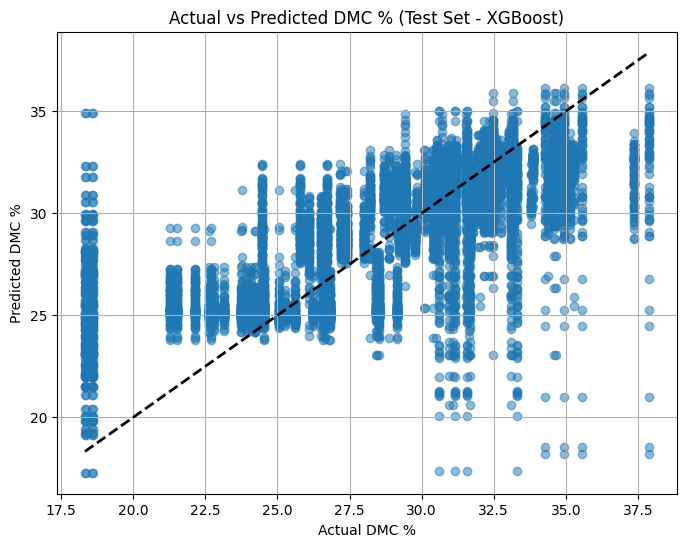

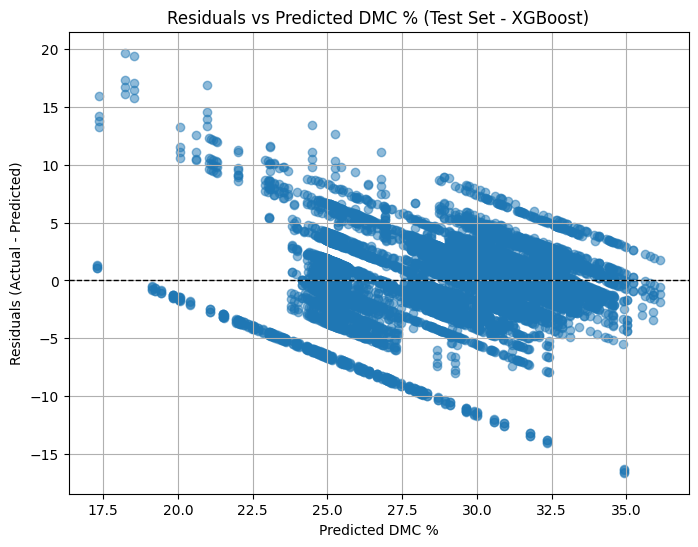


✅ XGBoost Model Training and Evaluation Completed.

🔬 Aplicando Validación Cruzada K-Fold para XGBoost...
   Usando datos combinados de Train y Validation (n=36840)

--- Fold 1/5 (XGBoost) ---
   Entrenando XGBoost para el fold...
   Entrenamiento del fold finalizado.
   Métricas del Fold (XGBoost):
     MSE: 5.0379
     RMSE: 2.2445
     R2: 0.7046

--- Fold 2/5 (XGBoost) ---
   Entrenando XGBoost para el fold...
   Entrenamiento del fold finalizado.
   Métricas del Fold (XGBoost):
     MSE: 5.0724
     RMSE: 2.2522
     R2: 0.6911

--- Fold 3/5 (XGBoost) ---
   Entrenando XGBoost para el fold...
   Entrenamiento del fold finalizado.
   Métricas del Fold (XGBoost):
     MSE: 5.2487
     RMSE: 2.2910
     R2: 0.6889

--- Fold 4/5 (XGBoost) ---
   Entrenando XGBoost para el fold...
   Entrenamiento del fold finalizado.
   Métricas del Fold (XGBoost):
     MSE: 5.1791
     RMSE: 2.2758
     R2: 0.6862

--- Fold 5/5 (XGBoost) ---
   Entrenando XGBoost para el fold...
   Entrenamiento del

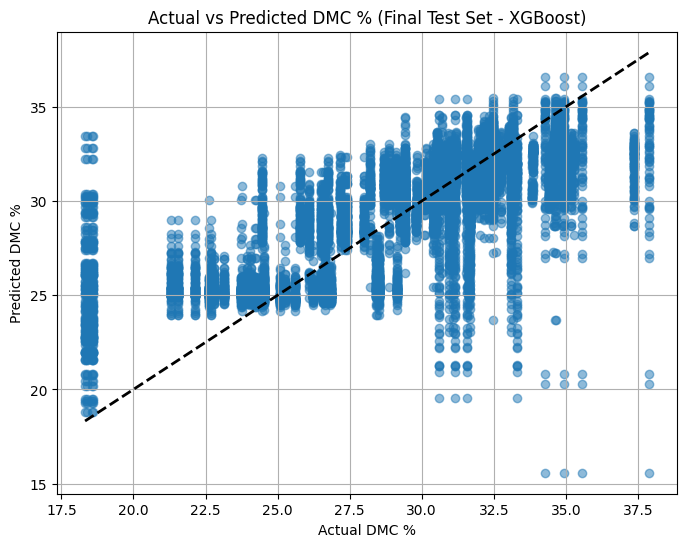

In [ ]:
# prompt: APLICAR XGBOOST

# --- XGBoost Model Training ---
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import KFold # Import KFold for cross-validation
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting

# Use the cleaned, merged dataframes from the MLP section
# Define features (PCA components) and target (DMC %) for XGBoost
# We use the same X_train, y_train, X_vali, y_vali, X_test, y_test defined previously
# which were derived from train_df_merged, vali_df_merged, test_df_merged

# Ensure the data variables are available, use copies to avoid modifying original DataFrames
if 'X_train_final' not in locals() or 'y_train' not in locals() or \
   'X_vali_final' not in locals() or 'y_vali' not in locals() or \
   'X_test_final' not in locals() or 'y_test_final' not in locals():
    print("\nError: Required data variables (X_train_final, y_train, etc.) are not available. Please run the previous data merging cell.")
else:
    X_train_xgbr = X_train_final.copy()
    y_train_xgbr = y_train.copy()

    X_vali_xgbr = X_vali_final.copy()
    y_vali_xgbr = y_vali.copy()

    X_test_xgbr = X_test_final.copy()
    y_test_xgbr = y_test_final.copy()

    print("\n🚀 Training XGBoost Regressor...")

    # Initialize the XGBoost Regressor
    # You can adjust parameters like objective, n_estimators, learning_rate, max_depth, etc.
    xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Regression task with squared error
                            n_estimators=100,         # Number of boosting rounds (trees)
                            learning_rate=0.1,        # Step size shrinkage
                            max_depth=6,              # Maximum depth of trees
                            random_state=42,
                            n_jobs=-1)                # Use all available cores

    # Train the model on the training data
    print("Fitting XGBoost on training data...")
    # Remove early_stopping_rounds and verbose from the fit method for the scikit-learn API
    xgbr.fit(X_train_xgbr, y_train_xgbr,
             eval_set=[(X_vali_xgbr, y_vali_xgbr)]) # Keep eval_set if you want to monitor performance

    print("XGBoost training finished.")


    # --- Model Evaluation (XGBoost) ---
    print("\nEvaluating XGBoost Regressor:")

    # Predictions on Validation Set
    y_vali_pred_xgbr = xgbr.predict(X_vali_xgbr)

    # Calculate metrics for Validation Set
    mse_vali_xgbr = mean_squared_error(y_vali_xgbr, y_vali_pred_xgbr)
    rmse_vali_xgbr = sqrt(mse_vali_xgbr)
    r2_vali_xgbr = r2_score(y_vali_xgbr, y_vali_pred_xgbr)

    print(f"   Validation Set (XGBoost):")
    print(f"     MSE: {mse_vali_xgbr:.4f}")
    print(f"     RMSE: {rmse_vali_xgbr:.4f}")
    print(f"     R2: {r2_vali_xgbr:.4f}")

    # Predictions on Test Set
    y_test_pred_xgbr = xgbr.predict(X_test_xgbr)

    # Calculate metrics for Test Set
    mse_test_xgbr = mean_squared_error(y_test_xgbr, y_test_pred_xgbr)
    rmse_test_xgbr = sqrt(mse_test_xgbr)
    r2_test_xgbr = r2_score(y_test_xgbr, y_test_pred_xgbr)

    print(f"   Test Set (XGBoost):")
    print(f"     MSE: {mse_test_xgbr:.4f}")
    print(f"     RMSE: {rmse_test_xgbr:.4f}")
    print(f"     R2: {r2_test_xgbr:.4f}")

    # Optional: Plotting predicted vs actual values for the test set (XGBoost)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_xgbr, y_test_pred_xgbr, alpha=0.5)
    plt.title('Actual vs Predicted DMC % (Test Set - XGBoost)')
    plt.xlabel('Actual DMC %')
    plt.ylabel('Predicted DMC %')
    plt.plot([y_test_xgbr.min(), y_test_xgbr.max()], [y_test_xgbr.min(), y_test_xgbr.max()], 'k--', lw=2) # Diagonal line
    plt.grid(True)
    plt.show()

    # Optional: Plotting residuals (XGBoost)
    residuals_test_xgbr = y_test_xgbr - y_test_pred_xgbr
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_pred_xgbr, residuals_test_xgbr, alpha=0.5)
    plt.title('Residuals vs Predicted DMC % (Test Set - XGBoost)')
    plt.xlabel('Predicted DMC %')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.axhline(y=0, color='k', linestyle='--', lw=1) # Zero line
    plt.grid(True)
    plt.show()

    print("\n✅ XGBoost Model Training and Evaluation Completed.")

# --- XGBoost Cross-Validation (Optional) ---
# Using the combined train/validation data (X_train_combined, y_train_combined) from the MLP cross-validation section

# Check if X_train_combined and y_train_combined are available from the MLP cross-validation cell
if 'X_train_combined' not in locals() or 'y_train_combined' not in locals() or len(X_train_combined) == 0:
    print("\nError: Combined train/validation data (X_train_combined, y_train_combined) not available or is empty. Cannot perform XGBoost cross-validation.")
else:
    print("\n🔬 Aplicando Validación Cruzada K-Fold para XGBoost...")
    print(f"   Usando datos combinados de Train y Validation (n={len(X_train_combined)})")

    # Configure K-Fold Cross-Validation (using the same kf object if desired, or a new one)
    n_splits = 5 # Already defined in MLP CV cell
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) # Use the same KFold split as before

    # Store results from each fold
    mse_scores_xgbr_cv = []
    rmse_scores_xgbr_cv = []
    r2_scores_xgbr_cv = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_combined, y_train_combined)):
        print(f"\n--- Fold {fold + 1}/{n_splits} (XGBoost) ---")

        # Split data into fold train and fold validation sets
        # Use .iloc for positional indexing with numpy arrays from kf.split
        X_train_fold_xgbr, X_val_fold_xgbr = X_train_combined.iloc[train_index], X_train_combined.iloc[val_index]
        y_train_fold_xgbr, y_val_fold_xgbr = y_train_combined.iloc[train_index], y_train_combined.iloc[val_index]


        # Initialize a new XGBoost Regressor model for each fold
        # Use the same parameters as before, or tune them if needed
        xgbr_fold = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=100,
                                   learning_rate=0.1,
                                   max_depth=6,
                                   random_state=42,
                                   n_jobs=-1)

        print("   Entrenando XGBoost para el fold...")
        # Remove early_stopping_rounds and verbose from the fit method for the scikit-learn API
        # Use eval_set with the validation data for monitoring if needed, but not required for basic CV
        xgbr_fold.fit(X_train_fold_xgbr, y_train_fold_xgbr)

        print("   Entrenamiento del fold finalizado.")

        # Evaluate the model on the validation fold
        y_val_pred_fold_xgbr = xgbr_fold.predict(X_val_fold_xgbr)

        # Calculate metrics
        mse_fold_xgbr = mean_squared_error(y_val_fold_xgbr, y_val_pred_fold_xgbr)
        rmse_fold_xgbr = sqrt(mse_fold_xgbr)
        r2_fold_xgbr = r2_score(y_val_fold_xgbr, y_val_pred_fold_xgbr)

        mse_scores_xgbr_cv.append(mse_fold_xgbr)
        rmse_scores_xgbr_cv.append(rmse_fold_xgbr)
        r2_scores_xgbr_cv.append(r2_fold_xgbr)

        print(f"   Métricas del Fold (XGBoost):")
        print(f"     MSE: {mse_fold_xgbr:.4f}")
        print(f"     RMSE: {rmse_fold_xgbr:.4f}")
        print(f"     R2: {r2_fold_xgbr:.4f}")

    # Print average and standard deviation of the metrics across all folds
    print("\n--- Resultados Promedio de Validación Cruzada (XGBoost) ---")
    print(f"   MSE Promedio: {np.mean(mse_scores_xgbr_cv):.4f} (+/- {np.std(mse_scores_xgbr_cv):.4f})")
    print(f"   RMSE Promedio: {np.mean(rmse_scores_xgbr_cv):.4f} (+/- {np.std(rmse_scores_xgbr_cv):.4f})")
    print(f"   R2 Promedio: {np.mean(r2_scores_xgbr_cv):.4f} (+/- {np.std(r2_scores_xgbr_cv):.4f})")

    print("\n✅ Validación Cruzada para XGBoost Completada.")

    # You can now train the final XGBoost model on the entire X_train_combined, y_train_combined dataset
    # and evaluate it on the separate X_test_final, y_test_final set (which was held out from the beginning).
    print("\n🚀 Entrenando el modelo final XGBoost en todos los datos de Train+Validation...")

    final_xgbr = xgb.XGBRegressor(objective='reg:squarederror',
                                  n_estimators=100,
                                  learning_rate=0.1,
                                  max_depth=6,
                                  random_state=42,
                                  n_jobs=-1)

    # Fit on the combined data without explicit early stopping eval_set here
    final_xgbr.fit(X_train_combined, y_train_combined)

    print("Entrenamiento del modelo final XGBoost completado.")

    # Evaluate the final XGBoost model on the held-out test set
    if 'X_test_final' in locals() and 'y_test_final' in locals() and not X_test_final.empty:
        print("\n--- Evaluación del Modelo Final XGBoost en el Conjunto de Test ---")
        y_test_pred_final_xgbr = final_xgbr.predict(X_test_final)

        mse_test_final_xgbr = mean_squared_error(y_test_final, y_test_pred_final_xgbr)
        rmse_test_final_xgbr = sqrt(mse_test_final_xgbr)
        r2_test_final_xgbr = r2_score(y_test_final, y_test_pred_final_xgbr)

        print(f"   Conjunto de Test (held-out - XGBoost):")
        print(f"     MSE: {mse_test_final_xgbr:.4f}")
        print(f"     RMSE: {rmse_test_final_xgbr:.4f}")
        print(f"     R2: {r2_test_final_xgbr:.4f}")

        # Optional: Plotting predicted vs actual values for the final test set (XGBoost)
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test_final, y_test_pred_final_xgbr, alpha=0.5)
        plt.title('Actual vs Predicted DMC % (Final Test Set - XGBoost)')
        plt.xlabel('Actual DMC %')
        plt.ylabel('Predicted DMC %')
        plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'k--', lw=2) # Diagonal line
        plt.grid(True)
        plt.show()

    else:
         print("\nError: El conjunto de Test (X_test_final, y_test_final) no está disponible o está vacío. No se puede evaluar el modelo final XGBoost.")